# ПРОЕКТ

# оптимизация производственных расходов металлургического комбината

# Описание проекта

Цель проекта - оптимизировать производственные расходы путем снижения расходов на электроэнергию. Заказчик -  металлургический комбинат ООО «Так закаляем сталь». Заказчик решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали. 

**Описание технического процесса от заказчика**
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Дополнительная информация**





В ходе обсуждений с заказчиком получена дополнительная информация:
1. Установлена целевая переменная - это конечная температура розлива металла. Паспортная температура плавления - около 1500 градусов С. Поднимать температуру выше не нужно, так как уже достигнуто плавление содержимого ковша.
2. Превышение температуры нежелательно ещё и потому, что ведет к разрушению облицовки и повышенному износу, помимо экономии электроэнергии, при снижении температуры достигается экономия средств на планово-профилактический ремонт.
3. Газ используется для перемешивания раствора в ковше.
4. Объект моделирования – ковш. 


In [64]:
!pip install ydata_profiling
#!pip install pandas-profiling

# Изучение данных

Импорт библиотек

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
import warnings
import re

import ydata_profiling

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import  make_scorer
#from scipy import stats as st

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv

Скрытие предупреждений

In [66]:
pd.options.mode.chained_assignment = None

warnings.filterwarnings('ignore')

Константы

In [67]:
RANDOM_STATE = 130223
SEC= timedelta(seconds = 1)

Импорт данных

In [68]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas= pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp= pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire= pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time= pd.read_csv('/datasets/final_steel/data_wire_time.csv')


### Описание данных от источника данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [69]:
#Функция для проверки пропусков в данных:
def gaps(datafile):
    gap_columns = []
    for column in datafile.columns:
        if datafile[column].count() < datafile.shape[0]:
            gap_columns.append(column)
    
    full_columns = []
    for column in datafile.columns:
        if datafile[column].count() == datafile.shape[0]:
            full_columns.append(column)
    gaps_text = ('Таблица представляет собой массив из ' + str(datafile.shape[1]) 
                 + ' столбцов и '+ str(datafile.shape[0]) + ' строк. ' +
                'Таблица содержит пропуски в столбцах ' + str(gap_columns) + '. Пропуски в ' + str(len(gap_columns)) + ' столбцах из ' + str(datafile.shape[1])
                 +'. Полностью заполнены и не содержат пропусков столбцы ' + str(full_columns) 
                 + ', всего ' + str(len(full_columns)) + ' полностью заполненных столбцов.')
    return gaps_text



In [70]:
data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time ]
data_names = ['data_arc: данные об электродах','data_bulk: данные о подаче сыпучих материалов (объём)',
              'data_bulk_time: данные о подаче сыпучих материалов (время)',  'data_gas: данные о продувке сплава газом', 
              'data_temp: результаты измерения температуры','data_wire: данные о проволочных материалах (объём)', 
              'data_wire_time: данные о проволочных материалах (время)']
for index in range(len(data_list)):
    print('\033[1m' + data_names[index] + '\033[0m' )
    print(gaps(data_list[index]))
    print("")

data_arc: данные об электродах
Таблица представляет собой массив из 5 столбцов и 14876 строк. Таблица содержит пропуски в столбцах []. Пропуски в 0 столбцах из 5. Полностью заполнены и не содержат пропусков столбцы ['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность'], всего 5 полностью заполненных столбцов.

data_bulk: данные о подаче сыпучих материалов (объём)
Таблица представляет собой массив из 16 столбцов и 3129 строк. Таблица содержит пропуски в столбцах ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']. Пропуски в 15 столбцах из 16. Полностью заполнены и не содержат пропусков столбцы ['key'], всего 1 полностью заполненных столбцов.

data_bulk_time: данные о подаче сыпучих материалов (время)
Таблица представляет собой массив из 16 столбцов и 3129 строк. Таблица содержит пропуски в столбцах ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 

Таблицы содержат пропуски в столбцах, 
* data_arc - полностью заполнен. 
* data_bulk - Пропуски в 15 столбцах из 16. Полностью заполнены и не содержат пропусков только столбец ['key'],
* data_bulk_time - то же самое,
* data_gas - - полностью заполнен,
* data_temp - таблица с температурой содержит пропуски в столбце ['Температура']. 
* data_wire, data_wire_time - Пропуски в 9 столбцах из 10, полностью заполнен опять только столбец key.

Произведём первичную проверку данных:

In [71]:
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)
    
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    try:
        display(data_df.describe(include='object').T) 
       
        print('\033[1m' + '\nВывод уникальных значений по каждому категориальному признаку:'+ '\033[0m')    
        df_object = data_df.select_dtypes(include='object').columns
    
        for i in df_object:
            print('\033[1m' + '_'+ str(i) + '\033[0m')
            display(data_df[i].value_counts())
    except:
        print('нет')

In [72]:
for index in range(len(data_list)):
    print('\033[1m' + data_names[index] + '\033[0m' )
    check_data(data_list[index])
    print("")


data_arc: данные об электродах
Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388



Описание категориальных данных:


,count,unique,top,freq
Начало нагрева дугой,14876,14875,2019-06-10 22:02:03,2
Конец нагрева дугой,14876,14876,2019-06-17 20:10:52,1



Вывод уникальных значений по каждому категориальному признаку:
_Начало нагрева дугой


2019-06-10 22:02:03    2
2019-08-24 04:27:37    1
2019-08-23 13:40:09    1
2019-06-30 05:38:28    1
2019-05-20 13:07:28    1
                      ..
2019-05-19 16:07:11    1
2019-08-25 10:14:16    1
2019-06-28 22:16:30    1
2019-08-18 11:16:17    1
2019-08-02 05:44:53    1
Name: Начало нагрева дугой, Length: 14875, dtype: int64

_Конец нагрева дугой


2019-06-17 20:10:52    1
2019-08-09 03:59:53    1
2019-08-08 02:11:14    1
2019-08-06 00:04:53    1
2019-08-30 06:14:20    1
                      ..
2019-08-06 23:49:44    1
2019-08-14 08:31:35    1
2019-06-17 18:54:39    1
2019-08-17 01:30:05    1
2019-05-27 02:41:46    1
Name: Конец нагрева дугой, Length: 14876, dtype: int64


data_bulk: данные о подаче сыпучих материалов (объём)
Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

Проверка пропусков
Количество пропусков: 35776
Доля пропусков: 76.2%
Дол

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0



Описание категориальных данных:
нет

data_bulk_time: данные о подаче сыпучих материалов (время)
Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

Проверка пропусков
Количество пропусков: 35776
Д

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0



Описание категориальных данных:


,count,unique,top,freq
Bulk 1,252,252,2019-08-21 19:37:56,1
Bulk 2,22,22,2019-07-23 15:37:44,1
Bulk 3,1298,1298,2019-06-06 10:26:14,1
Bulk 4,1014,1014,2019-08-27 03:15:03,1
Bulk 5,77,77,2019-08-27 03:15:03,1
Bulk 6,576,576,2019-05-16 17:17:17,1
Bulk 7,25,25,2019-05-15 09:35:53,1
Bulk 8,1,1,2019-07-05 17:46:11,1
Bulk 9,19,19,2019-05-14 04:38:14,1
Bulk 10,176,176,2019-05-20 14:23:52,1



Вывод уникальных значений по каждому категориальному признаку:
_Bulk 1


2019-08-21 19:37:56    1
2019-05-17 02:40:29    1
2019-05-23 15:30:11    1
2019-06-17 02:34:38    1
2019-07-03 15:20:24    1
                      ..
2019-05-09 04:35:17    1
2019-07-01 08:55:05    1
2019-07-09 13:36:02    1
2019-07-02 22:31:41    1
2019-05-21 11:39:25    1
Name: Bulk 1, Length: 252, dtype: int64

_Bulk 2


2019-07-23 15:37:44    1
2019-05-07 10:05:35    1
2019-05-07 17:38:50    1
2019-08-08 15:21:12    1
2019-05-07 08:36:19    1
2019-07-23 11:52:43    1
2019-07-23 08:42:23    1
2019-08-08 17:34:38    1
2019-05-07 11:37:42    1
2019-08-08 09:34:53    1
2019-07-23 11:10:20    1
2019-07-23 10:13:13    1
2019-08-08 08:44:52    1
2019-08-08 14:33:22    1
2019-07-23 18:01:50    1
2019-05-07 15:45:34    1
2019-08-08 11:51:23    1
2019-08-08 16:12:17    1
2019-05-07 16:27:56    1
2019-07-23 14:35:55    1
2019-08-08 11:08:58    1
2019-08-08 10:16:41    1
Name: Bulk 2, dtype: int64

_Bulk 3


2019-06-06 10:26:14    1
2019-05-13 18:29:09    1
2019-05-31 08:21:52    1
2019-07-16 13:10:20    1
2019-07-01 15:20:13    1
                      ..
2019-08-03 12:09:33    1
2019-08-27 19:08:53    1
2019-07-09 13:41:38    1
2019-07-18 15:04:39    1
2019-06-30 17:10:30    1
Name: Bulk 3, Length: 1298, dtype: int64

_Bulk 4


2019-08-27 03:15:03    1
2019-07-30 03:27:37    1
2019-05-25 11:42:44    1
2019-07-16 16:25:02    1
2019-06-25 09:56:21    1
                      ..
2019-06-01 11:40:09    1
2019-08-29 20:34:41    1
2019-07-15 18:48:20    1
2019-08-05 09:06:48    1
2019-08-08 17:34:38    1
Name: Bulk 4, Length: 1014, dtype: int64

_Bulk 5


2019-08-27 03:15:03    1
2019-05-07 11:37:42    1
2019-08-27 04:41:19    1
2019-07-02 03:00:23    1
2019-07-01 22:19:07    1
                      ..
2019-08-28 01:33:02    1
2019-06-17 19:01:49    1
2019-07-01 23:42:34    1
2019-08-28 08:23:07    1
2019-08-08 10:16:41    1
Name: Bulk 5, Length: 77, dtype: int64

_Bulk 6


2019-05-16 17:17:17    1
2019-05-29 14:55:29    1
2019-08-12 03:59:17    1
2019-06-05 08:16:41    1
2019-05-14 23:25:54    1
                      ..
2019-08-25 08:33:09    1
2019-05-05 14:20:57    1
2019-08-02 05:58:33    1
2019-05-27 13:20:01    1
2019-08-19 06:44:11    1
Name: Bulk 6, Length: 576, dtype: int64

_Bulk 7


2019-05-15 09:35:53    1
2019-07-23 11:10:20    1
2019-08-08 12:03:38    1
2019-08-08 10:27:58    1
2019-08-31 07:22:25    1
2019-07-23 11:52:43    1
2019-08-31 06:55:58    1
2019-08-31 06:20:47    1
2019-06-21 14:05:53    1
2019-07-23 08:42:23    1
2019-08-08 17:34:38    1
2019-05-07 11:37:42    1
2019-07-23 10:13:13    1
2019-07-23 15:37:44    1
2019-08-08 11:21:17    1
2019-08-08 09:38:06    1
2019-07-17 10:30:04    1
2019-07-23 18:01:50    1
2019-08-08 08:46:28    1
2019-08-08 16:25:14    1
2019-07-23 14:35:55    1
2019-07-17 07:14:04    1
2019-06-15 00:42:38    1
2019-08-08 14:45:03    1
2019-07-17 11:25:12    1
Name: Bulk 7, dtype: int64

_Bulk 8


2019-07-05 17:46:11    1
Name: Bulk 8, dtype: int64

_Bulk 9


2019-05-14 04:38:14    1
2019-07-18 17:35:46    1
2019-05-14 02:23:06    1
2019-07-18 18:58:01    1
2019-08-11 14:33:19    1
2019-08-11 11:12:43    1
2019-05-14 05:15:06    1
2019-05-14 03:30:41    1
2019-08-11 12:13:43    1
2019-08-11 13:54:18    1
2019-08-11 15:09:33    1
2019-05-14 01:45:42    1
2019-05-14 04:01:02    1
2019-05-14 02:51:41    1
2019-07-05 17:44:46    1
2019-08-11 13:20:19    1
2019-05-14 00:37:47    1
2019-05-14 01:09:57    1
2019-05-14 00:04:56    1
Name: Bulk 9, dtype: int64

_Bulk 10


2019-05-20 14:23:52    1
2019-05-20 10:46:30    1
2019-05-17 09:50:19    1
2019-07-03 11:56:07    1
2019-08-23 15:00:17    1
                      ..
2019-06-18 13:30:45    1
2019-08-28 20:30:58    1
2019-07-15 12:38:33    1
2019-06-25 15:42:19    1
2019-07-03 10:31:05    1
Name: Bulk 10, Length: 176, dtype: int64

_Bulk 11


2019-08-09 03:55:11    1
2019-07-17 12:12:17    1
2019-06-10 01:07:30    1
2019-07-20 17:30:01    1
2019-05-08 06:34:30    1
                      ..
2019-06-15 06:29:37    1
2019-06-12 01:47:51    1
2019-06-06 05:22:30    1
2019-08-31 15:01:05    1
2019-07-30 06:00:56    1
Name: Bulk 11, Length: 177, dtype: int64

_Bulk 12


2019-05-22 13:17:36    1
2019-06-24 15:32:56    1
2019-07-30 23:23:38    1
2019-06-23 07:55:28    1
2019-06-01 10:45:48    1
                      ..
2019-08-06 01:59:25    1
2019-07-20 00:53:14    1
2019-08-23 15:27:23    1
2019-05-16 16:13:58    1
2019-05-28 00:41:41    1
Name: Bulk 12, Length: 2450, dtype: int64

_Bulk 13


2019-05-15 17:09:56    1
2019-05-10 16:46:26    1
2019-08-21 07:35:23    1
2019-05-26 20:42:03    1
2019-06-07 12:36:20    1
2019-06-19 13:06:49    1
2019-07-02 18:49:35    1
2019-08-02 20:51:12    1
2019-05-05 00:39:35    1
2019-05-10 21:16:38    1
2019-06-29 19:39:20    1
2019-07-08 02:53:15    1
2019-07-24 23:34:05    1
2019-05-31 04:40:34    1
2019-08-24 11:33:10    1
2019-08-26 20:31:16    1
2019-08-17 18:32:34    1
2019-06-28 01:03:50    1
Name: Bulk 13, dtype: int64

_Bulk 14


2019-05-22 13:17:36    1
2019-05-25 15:28:48    1
2019-06-21 13:11:02    1
2019-07-05 16:52:57    1
2019-06-09 06:00:32    1
                      ..
2019-05-06 15:41:26    1
2019-06-26 12:02:17    1
2019-08-31 04:38:59    1
2019-05-18 00:05:48    1
2019-08-18 19:18:46    1
Name: Bulk 14, Length: 2806, dtype: int64

_Bulk 15


2019-05-22 13:17:36    1
2019-06-24 15:32:56    1
2019-06-23 07:55:28    1
2019-06-01 10:45:48    1
2019-08-30 16:16:33    1
                      ..
2019-06-17 03:34:20    1
2019-05-18 19:16:25    1
2019-07-16 04:07:36    1
2019-07-21 01:41:07    1
2019-05-28 00:41:41    1
Name: Bulk 15, Length: 2248, dtype: int64


data_gas: данные о продувке сплава газом
Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504



Описание категориальных данных:
нет

data_temp: результаты измерения температуры
Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

Проверка пропусков
Количество пропусков: 2901
Доля пропусков: 9.1%
Доля строк содержащих пропуски: 18.2%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0



Описание категориальных данных:


,count,unique,top,freq
Время замера,15907,15907,2019-06-10 04:08:24,1



Вывод уникальных значений по каждому категориальному признаку:
_Время замера


2019-06-10 04:08:24    1
2019-05-11 19:56:21    1
2019-07-15 15:07:20    1
2019-06-01 18:58:18    1
2019-05-10 05:58:01    1
                      ..
2019-08-15 22:10:57    1
2019-06-05 05:37:02    1
2019-05-25 18:14:46    1
2019-06-08 06:20:07    1
2019-08-12 22:20:24    1
Name: Время замера, Length: 15907, dtype: int64


data_wire: данные о проволочных материалах (объём)
Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

Проверка пропусков
Количество пропусков: 23385
Доля пропусков: 84.3%
Доля строк содержащих пропуски: 100.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604



Описание категориальных данных:
нет

data_wire_time: данные о проволочных материалах (время)
Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

Проверка пропусков
Количество пропусков: 23385
Доля пропусков: 84.3%
Доля строк содержащих пропуски: 100.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0



Описание категориальных данных:


,count,unique,top,freq
Wire 1,3055,3055,2019-08-31 06:54:40,1
Wire 2,1079,1079,2019-05-08 20:59:05,1
Wire 3,63,63,2019-07-23 18:07:01,1
Wire 4,14,14,2019-07-17 11:25:32,1
Wire 5,1,1,2019-08-08 16:01:07,1
Wire 6,73,73,2019-08-09 05:37:32,1
Wire 7,11,11,2019-07-23 12:08:44,1
Wire 8,19,19,2019-07-18 17:36:23,1
Wire 9,29,29,2019-08-04 19:49:15,1



Вывод уникальных значений по каждому категориальному признаку:
_Wire 1


2019-08-31 06:54:40    1
2019-05-25 11:14:53    1
2019-05-06 19:03:36    1
2019-05-25 18:08:28    1
2019-06-08 13:33:38    1
                      ..
2019-08-05 08:08:53    1
2019-07-06 21:31:12    1
2019-08-04 04:59:19    1
2019-06-23 23:03:44    1
2019-07-03 10:30:16    1
Name: Wire 1, Length: 3055, dtype: int64

_Wire 2


2019-05-08 20:59:05    1
2019-07-25 17:13:29    1
2019-05-20 00:33:04    1
2019-06-30 10:34:35    1
2019-08-02 19:25:46    1
                      ..
2019-05-19 00:09:58    1
2019-05-03 23:05:53    1
2019-06-22 14:18:43    1
2019-05-12 05:46:25    1
2019-07-01 14:08:03    1
Name: Wire 2, Length: 1079, dtype: int64

_Wire 3


2019-07-23 18:07:01    1
2019-08-27 07:52:00    1
2019-08-08 14:40:37    1
2019-08-27 08:50:52    1
2019-08-21 05:33:09    1
                      ..
2019-06-12 01:29:02    1
2019-05-04 04:47:53    1
2019-05-18 20:52:18    1
2019-07-23 11:58:58    1
2019-07-23 08:50:46    1
Name: Wire 3, Length: 63, dtype: int64

_Wire 4


2019-07-17 11:25:32    1
2019-08-08 12:03:12    1
2019-05-07 08:48:23    1
2019-07-23 11:52:57    1
2019-05-07 16:09:18    1
2019-07-23 15:42:50    1
2019-07-23 11:12:30    1
2019-07-23 10:16:15    1
2019-05-07 10:14:55    1
2019-07-23 08:44:49    1
2019-07-23 14:40:29    1
2019-07-23 18:09:32    1
2019-08-08 09:00:26    1
2019-07-17 07:15:28    1
Name: Wire 4, dtype: int64

_Wire 5


2019-08-08 16:01:07    1
Name: Wire 5, dtype: int64

_Wire 6


2019-08-09 05:37:32    1
2019-07-26 14:29:00    1
2019-07-23 11:53:52    1
2019-08-13 19:57:19    1
2019-08-08 10:16:47    1
                      ..
2019-07-25 03:12:12    1
2019-08-08 20:28:45    1
2019-05-07 21:41:02    1
2019-08-08 11:08:50    1
2019-07-24 00:16:25    1
Name: Wire 6, Length: 73, dtype: int64

_Wire 7


2019-07-23 12:08:44    1
2019-08-08 10:01:56    1
2019-08-08 10:43:30    1
2019-08-08 11:23:43    1
2019-08-08 18:27:34    1
2019-07-23 19:16:46    1
2019-08-08 12:21:19    1
2019-08-08 16:45:44    1
2019-08-08 13:05:02    1
2019-07-23 19:46:16    1
2019-07-23 12:42:00    1
Name: Wire 7, dtype: int64

_Wire 8


2019-07-18 17:36:23    1
2019-05-14 05:14:25    1
2019-05-14 01:44:34    1
2019-08-11 11:12:56    1
2019-05-14 03:29:28    1
2019-08-11 12:13:47    1
2019-05-14 02:21:43    1
2019-05-14 00:36:39    1
2019-08-11 13:54:30    1
2019-05-14 02:50:24    1
2019-08-11 15:09:29    1
2019-07-18 18:58:07    1
2019-08-11 13:20:31    1
2019-05-14 00:03:32    1
2019-05-14 03:59:47    1
2019-05-14 01:08:35    1
2019-05-14 04:37:08    1
2019-08-11 14:33:40    1
2019-07-05 17:34:22    1
Name: Wire 8, dtype: int64

_Wire 9


2019-08-04 19:49:15    1
2019-08-05 01:13:57    1
2019-06-01 09:54:01    1
2019-08-04 23:15:18    1
2019-06-07 21:03:47    1
2019-08-04 22:04:50    1
2019-08-05 00:21:11    1
2019-06-09 10:26:00    1
2019-06-07 14:29:39    1
2019-08-05 04:16:10    1
2019-06-01 07:26:42    1
2019-06-01 02:25:26    1
2019-06-09 08:20:14    1
2019-06-07 20:28:19    1
2019-06-07 21:42:24    1
2019-07-02 05:22:29    1
2019-05-04 16:09:11    1
2019-06-07 23:25:28    1
2019-06-01 04:57:26    1
2019-07-02 06:41:51    1
2019-08-05 02:48:39    1
2019-07-02 12:29:04    1
2019-06-01 05:45:01    1
2019-06-07 22:47:35    1
2019-08-04 20:48:59    1
2019-07-02 08:17:45    1
2019-08-29 03:51:31    1
2019-06-07 23:59:16    1
2019-07-02 13:04:13    1
Name: Wire 9, dtype: int64

Мы посмотрели на данные, везде даты не являются датами плюс очень много пропусков, нужно будет решать, что с ними делать. Особенно отличились данные по загрузке присадок и проволоки.

Посмотрим на уникальные значения ковшей:

In [73]:
data_arc['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [74]:
data_bulk['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [75]:
data_gas['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [76]:
data_temp['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [77]:
data_wire['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

У нас 3241 уникальный ключ во всех 5 таблицах.

In [78]:
for _ in data_list:
    print(_.head())
    print("")


   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397  

   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     N

Похоже, что в  data_arc активная и реактивная мощности связаны. Проверим

In [79]:
data_arc.corr()

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021382,-0.004396
Активная мощность,-0.021382,1.000000,0.054437
Реактивная мощность,-0.004396,0.054437,1.000000


Да, между активной и реактивной мощностью есть слабая прямая корреляция. 

In [80]:
for _ in data_list:
    print(_.info())
    print("")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25

Видим, что в столбцах время постоянно записано как object, нужно исправить. Проверим разброс значений:

In [81]:
for _ in data_list:
    print(_.describe())
    print("")

                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000

Много пока ценной и непонятной информации, но вот и первые видимые на глаз выбросы: Реактивная мощность имеет минимум -715. Шалишь, мощность отрицательной быть не может. 

In [82]:
data_arc[data_arc['Реактивная мощность']<=0]


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Всего одно значение, экспозиция небольшая. Заполним по медиане:

In [83]:
data_arc.loc[data_arc['Реактивная мощность']<=0, 'Реактивная мощность'] = (0.495782*data_arc['Реактивная мощность'].median()/
                                                                    data_arc['Активная мощность'].median())

In [84]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.500715
std,934.571502,0.408159,0.310872
min,1.000000,0.030002,0.020806
25%,806.000000,0.395297,0.291008
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Чудно, а что с корреляцией?

In [85]:
data_arc.corr()

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021382,-0.000174
Активная мощность,-0.021382,1.000000,0.963182
Реактивная мощность,-0.000174,0.963182,1.000000


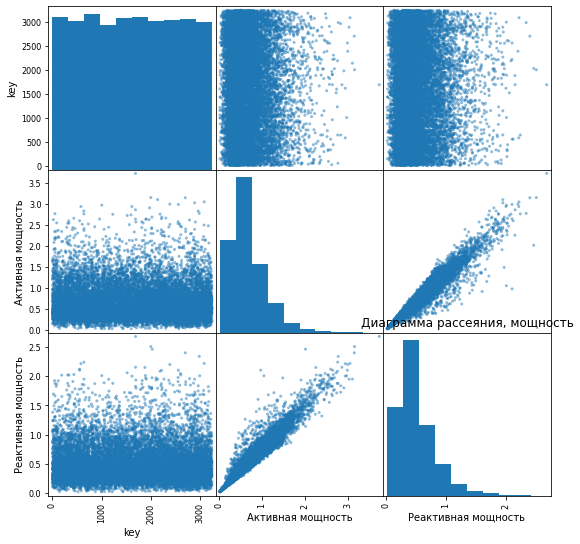

In [86]:
pd.plotting.scatter_matrix(data_arc, figsize=(9, 9))
plt.title('Диаграмма рассеяния, мощность')
plt.show()

Ого! Маленький шаг для реактивной мощности - и большой для данных в целом! Не подумала бы, что одно значение так тянет на дно. В итоге у нас сильная корреляция между активной и реактивной мощностью.  Тем не менее теперь мы видим, что у нас есть очень слабая обратная корреляция с номером партии, это означает, что с ростом номера мощность немного снижалась. Вообще, по мощности нужно будет посмотреть, поскольку именно с ней, группировкой на высокую и низкую, может быть связан наш искомый КПД 

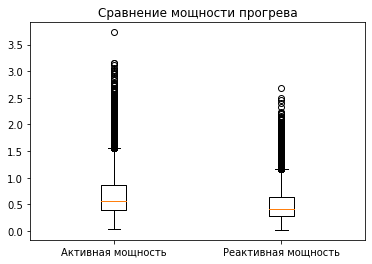

In [87]:
plt.boxplot([data_arc['Активная мощность'], data_arc['Реактивная мощность']], labels=['Активная мощность','Реактивная мощность'])
plt.title('Сравнение мощности прогрева')
plt.show()

На диаграмме видны выбросы, нужно проанализировать мощности выше 1,5/1,0.

**Вывод**

Таблицы содержат пропуски в столбцах, файлы с электродами и с газом не имеют пропусков, остальные - большое количество.
* data_arc - полностью заполнен. 
* data_bulk - Пропуски в 15 столбцах из 16. Полностью заполнены и не содержат пропусков только столбец ['key'],
* data_bulk_time - то же самое,
* data_gas - - полностью заполнен,
* data_temp - таблица с температурой содержит пропуски в столбце ['Температура']. 
* data_wire, data_wire_time - Пропуски в 9 столбцах из 10, полностью заполнен опять только столбец key.
Столбцы с датой имеют неверный тип данных. 
Наименования столбцов представлены строками в разных регистрах и на разных языках,  соотносятся с информацией в столбцах по смыслу).
Есть дисбаланс будущих признаков, поэтому в дальнейшем попробуем их сбалансировать.

## Предобработка данных

Обработать пропуски и выбросы. Заполнять пропуски в (data_bulk, data_bulk_time) и (data_wire, data_wire_time) я планирую нулями после их попарного объединения и проверки, что получится. Судя по всему, должно получиться похоже на OHE.

In [88]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [89]:
missed_cells = data_temp.isnull().sum().sum()/(data_temp.shape[0]*(data_temp.shape[1]-1))
missed_rows = sum(data_temp.isnull().sum(axis = 1)>0)/data_temp.shape[0]
print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
print ('Количество пропусков: {:.0f}'.format(data_temp.isnull().sum().sum()))
print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))


Проверка пропусков
Количество пропусков: 2901
Доля пропусков: 9.1%
Доля строк содержащих пропуски: 18.2%


In [90]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


вообще, конечно, пропуске в столбцe Температура  - это возмутительно, что у них там с лабораторной дисциплиной? Запросить мы не сможем, принимаем решение заполнять/удалять. Я склоняюсь к мысли **удалить**, заполнить мы могли бы только даннымии по предыдущему времени, корректности это точно не прибавит.

<AxesSubplot:ylabel='Frequency'>

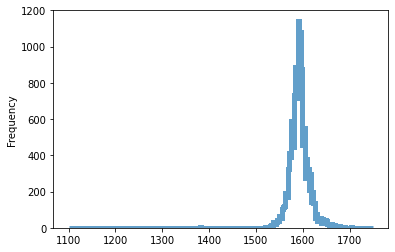

In [91]:
data_temp['Температура'].plot(
    kind='hist',
    histtype='step',
    range=(1100, 1750),
    bins=250,
    linewidth=5,
    alpha=0.7,
    label='raw',
)


В температуре пропуски 18.2%. Это много для удаления, но наша задача – создать качественную модель. В реальности нам нужно было бы дозапросить данные, по крайней мере – уточнить причину возникновения таких пропусков. Это следует отметить в отчете заказчику.
Мы не будем пользоваться временными рядами. Мы удалим не строки, а партию. 
в мощности корреляция 0.96 
По температуре есть несколько партий 1400. Такого не может быть, это ниже точки плавления. Но вдруг это связано с особыми присадками - нужно изучать. Это может быть и другой тип металла, так что учитываем и эти ковши.
В этом случае введём новую переменную, где 2 – обычные партии, а 0 – особые, меньше 1400, 1 - выше 1500 + допуск.



У нас нормальное распределение температуры.

In [92]:
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [93]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

Переименуем столбцы

In [94]:
data_temp.columns = ['key', 'sampling_time', 'temperature']

Вернем дате её свойства

In [95]:
data_temp['sampling_time'] = pd.to_datetime(data_temp['sampling_time'])

In [96]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            15907 non-null  int64         
 1   sampling_time  15907 non-null  datetime64[ns]
 2   temperature    13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [97]:
data_temp.head()

,key,sampling_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Всё ок, сделаем дополнительный столбец с целевой температурой: целевой температурой будем считать от 1470 до 1520 градусов.

In [98]:
def tempr_aim(row):
    if row['temperature'] < 1470:
        goal_tempr = 0
    elif row['temperature'] > 1520:
        goal_tempr = 1
    else:
        goal_tempr = 2

    return goal_tempr



Мы приняли решение не удалять выбросы, поскольку это может привести к потере данных, созданию модели - обрубка, неспособной работать с реально встречающимися диапазонами температур.

In [99]:
data_temp.head()

,key,sampling_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [100]:
data_temp.isna().sum()

key                 0
sampling_time       0
temperature      2901
dtype: int64

Уберем данные с пропускакми, выберем ковши, в которых встречаются пропуски:

In [101]:
out = data_temp.loc[np.isnan(data_temp['temperature']), 'key' ].unique()

out

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

In [102]:
data_temp = data_temp.loc[data_temp['key'].isin(out) == False]

In [103]:
data_temp

,key,sampling_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


Готово, проверим  теперь пропуски:

In [104]:
data_temp.isna().sum()

key              0
sampling_time    0
temperature      0
dtype: int64

Подготовим данные к объединению. Оставим первое измерение температуры (оно пойдет в признаки) и последнее, оно будет нашим целевым признаком.

In [105]:
pivot_temp = data_temp.pivot_table(index=['key'], 
                                   values=['sampling_time', 'temperature'], aggfunc=['first', 'last'])

In [106]:
pivot_temp

first                            last            
           sampling_time temperature       sampling_time temperature
key                                                                 
1    2019-05-03 11:16:18      1571.0 2019-05-03 11:30:39      1613.0
2    2019-05-03 11:37:27      1581.0 2019-05-03 11:59:12      1602.0
3    2019-05-03 12:13:17      1596.0 2019-05-03 12:34:57      1599.0
4    2019-05-03 12:52:57      1601.0 2019-05-03 12:59:25      1625.0
5    2019-05-03 13:23:19      1576.0 2019-05-03 13:36:01      1602.0
...                  ...         ...                 ...         ...
2495 2019-08-06 00:35:45      1570.0 2019-08-06 00:54:42      1591.0
2496 2019-08-06 01:02:54      1554.0 2019-08-06 01:29:52      1591.0
2497 2019-08-06 01:41:53      1571.0 2019-08-06 01:53:50      1589.0
2498 2019-08-06 02:03:49      1591.0 2019-08-06 02:25:31      1594.0
2499 2019-08-06 02:40:25      1569.0 2019-08-06 03:00:28      1603.0

[2477 rows x 4 columns]

In [107]:

pivot_temp.columns = [ 'first_sampling_time', 'first_temperature',  
                       'last_sampling_time', 'temperature']



In [108]:
pivot_temp.describe()
pivot_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   first_sampling_time  2477 non-null   datetime64[ns]
 1   first_temperature    2477 non-null   float64       
 2   last_sampling_time   2477 non-null   datetime64[ns]
 3   temperature          2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.8 KB


Не возникло ли новых пропусков?

In [109]:
pivot_temp.isna().sum()

first_sampling_time    0
first_temperature      0
last_sampling_time     0
temperature            0
dtype: int64

In [110]:
pivot_temp.describe()

,first_temperature,temperature
count,2477.000000,2477.000000
mean,1588.405733,1595.334275
std,29.232904,16.019339
min,1191.000000,1541.000000
25%,1572.000000,1587.000000
50%,1588.000000,1593.000000
75%,1605.000000,1599.000000
max,1679.000000,1700.000000


<AxesSubplot:ylabel='Frequency'>

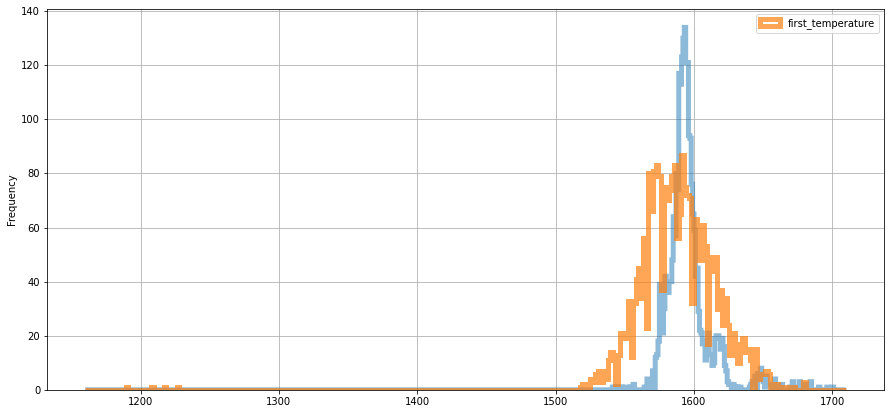

In [111]:
ax = pivot_temp['temperature'].plot(
    kind='hist',
    histtype='step',
    range=(1160, 1710),
    bins=550,
    linewidth=5,
    alpha=0.5,
    label='raw',
    figsize = (15,7)
)
pivot_temp['first_temperature'].plot(
    kind='hist',
    histtype='step',
    range=(1160, 1710),
    bins=300,
    linewidth=5,
    alpha=0.7,
    ax=ax,
    grid=True,
    legend=True,
)



А как вообще распрeделяется наша целевая температура?

array([[<AxesSubplot:xlabel='first_temperature', ylabel='first_temperature'>,
        <AxesSubplot:xlabel='temperature', ylabel='first_temperature'>],
       [<AxesSubplot:xlabel='first_temperature', ylabel='temperature'>,
        <AxesSubplot:xlabel='temperature', ylabel='temperature'>]],
      dtype=object)

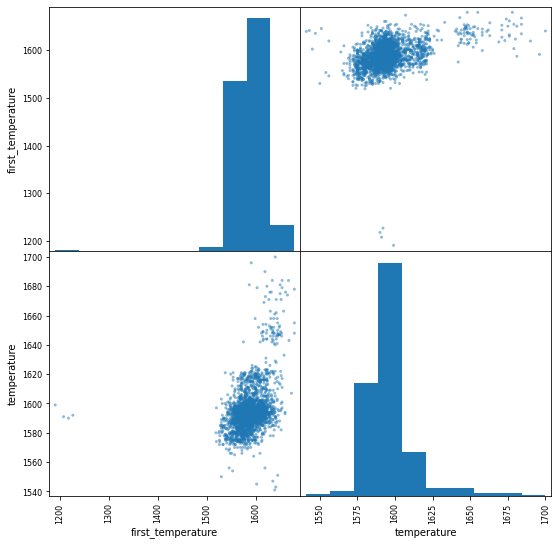

In [112]:
pd.plotting.scatter_matrix(pivot_temp[['first_temperature', 'temperature']], figsize=(9, 9)) 


In [113]:
pivot_temp.corr()

,first_temperature,temperature
first_temperature,1.00000,0.37669
temperature,0.37669,1.00000


In [114]:
def delta_t_temp(row):
    delta_time_temp = (row['last_sampling_time'] - row['first_sampling_time']) 
    return delta_time_temp

pivot_temp['delta_time_temp'] = pivot_temp.apply(delta_t_temp, axis=1)

In [115]:
pivot_temp['delta_time_temp'] = pivot_temp['delta_time_temp']/(60*SEC)

In [116]:
pivot_temp['goal_t'] = pivot_temp.apply(tempr_aim, axis=1)
pivot_temp

,first_sampling_time,first_temperature,last_sampling_time,temperature,delta_time_temp,goal_t
key,,,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,14.350000,1
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,21.750000,1
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,21.666667,1
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,6.466667,1
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,12.700000,1
...,...,...,...,...,...,...
2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0,18.950000,1
2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0,26.966667,1
2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0,11.950000,1


In [117]:
pivot_temp.corr()

,first_temperature,temperature,delta_time_temp,goal_t
first_temperature,1.000000,0.37669,0.125566,NaN
temperature,0.376690,1.00000,-0.004870,NaN
delta_time_temp,0.125566,-0.00487,1.000000,NaN
goal_t,NaN,NaN,NaN,NaN


Корреляции немного ставящие в тупик: чем выше была первоначальная температура - тем дольше грели/мешали... интересно. Может быть, что-то тугоплавкое, особо кристаллизующееся. Нужно отметить в отчёте.
Выбрасываем лишние столбцы - с датами.

In [243]:
pivot_temp.describe()

,key,first_temperature,temperature,delta_time_temp,goal_t
count,2477.000000,2477.000000,2477.000000,2477.000000,2477.0
mean,1249.968510,1588.405733,1595.334275,30.890937,1.0
std,720.073717,29.232904,16.019339,21.696387,0.0
min,1.000000,1191.000000,1541.000000,0.000000,1.0
25%,628.000000,1572.000000,1587.000000,19.683333,1.0
50%,1251.000000,1588.000000,1593.000000,26.516667,1.0
75%,1872.000000,1605.000000,1599.000000,37.700000,1.0
max,2499.000000,1679.000000,1700.000000,392.283333,1.0


In [118]:
pivot_temp = pivot_temp.drop(['last_sampling_time','first_sampling_time'], axis=1)

Переходим к нагреву:

In [119]:
data_arc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [120]:
data_arc.columns = ['key', 'start_time', 'end_time','active_capacity', 'reactive_capacity']

In [121]:
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'])
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'])

In [122]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   start_time         14876 non-null  datetime64[ns]
 2   end_time           14876 non-null  datetime64[ns]
 3   active_capacity    14876 non-null  float64       
 4   reactive_capacity  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [123]:
data_arc.head()

,key,start_time,end_time,active_capacity,reactive_capacity
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [124]:
def full_cap(row):
    full_capacity = round((row['active_capacity']**2 + row['active_capacity']**2) ** 0.5, 6)

    return full_capacity

data_arc['full_capacity'] = data_arc.apply(full_cap, axis=1)



In [126]:
def heat_time(row):
    heating_time = (row['end_time'] -  row['start_time']) / (3600*SEC)

    return heating_time

data_arc['heating_time'] = data_arc.apply(heat_time, axis=1)



Так как мощность измеряется в кВт/час - выражаем время прогрева в часах.

In [127]:
def work_arc(row):
    work_arc = row['heating_time'] *  row['full_capacity']

    return work_arc

data_arc['work_arc'] = data_arc.apply(work_arc, axis=1)



In [128]:
data_arc.head()

,key,start_time,end_time,active_capacity,reactive_capacity,full_capacity,heating_time,work_arc
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.380356,0.063333,0.087423
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,1.139300,0.051389,0.058547
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,1.052689,0.047778,0.050295
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2.346693,0.101389,0.237929
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.979703,0.041111,0.040277


In [129]:
data_arc.drop(['start_time','end_time','active_capacity', 'reactive_capacity' ], axis=1)

,key,full_capacity,heating_time,work_arc
0,1,1.380356,0.063333,0.087423
1,1,1.139300,0.051389,0.058547
2,1,1.052689,0.047778,0.050295
3,1,2.346693,0.101389,0.237929
4,1,0.979703,0.041111,0.040277
...,...,...,...,...
14871,3241,0.754723,0.043611,0.032914
14872,3241,0.956862,0.050000,0.047843
14873,3241,1.037891,0.051111,0.053048
14874,3241,0.312108,0.015833,0.004942


In [130]:
data_arc.corr()

,key,active_capacity,reactive_capacity,full_capacity,heating_time,work_arc
key,1.000000,-0.021382,-0.000174,-0.021382,-0.018363,-0.014645
active_capacity,-0.021382,1.000000,0.963182,1.000000,0.974128,0.937403
reactive_capacity,-0.000174,0.963182,1.000000,0.963182,0.971268,0.916576
full_capacity,-0.021382,1.000000,0.963182,1.000000,0.974128,0.937403
heating_time,-0.018363,0.974128,0.971268,0.974128,1.000000,0.932233
work_arc,-0.014645,0.937403,0.916576,0.937403,0.932233,1.000000


И тут ещё интереснее - чем больше мощность - тем ещё и дольше приходится греть! Что там за особенности техпроцесса - нам неизвестно, но они точно сложнее линейных. Принимаем решение использовать столбцы heating_time, full_capacity и heating_time	work_arc

In [131]:
pivot_arc = data_arc.pivot_table(index=['key'], 
                                   values=['full_capacity','heating_time', 'work_arc'], aggfunc=['mean','sum'])

In [132]:
pivot_arc.columns

MultiIndex([('mean', 'full_capacity'),
            ('mean',  'heating_time'),
            ('mean',      'work_arc'),
            ( 'sum', 'full_capacity'),
            ( 'sum',  'heating_time'),
            ( 'sum',      'work_arc')],
           )

In [133]:
pivot_arc.columns = ['s_full_capacity','sum_heating_time', 'sum_work_arc','mean_full_capacity','m_heating_time', 'mean_work_arc']

In [134]:
pivot_arc.columns

Index(['s_full_capacity', 'sum_heating_time', 'sum_work_arc',
       'mean_full_capacity', 'm_heating_time', 'mean_work_arc'],
      dtype='object')

In [135]:
pivot_arc = pivot_arc.drop(['s_full_capacity', 'm_heating_time'], axis=1)

In [136]:
pivot_arc.corr()

,sum_heating_time,sum_work_arc,mean_full_capacity,mean_work_arc
sum_heating_time,1.000000,0.929296,0.577088,0.730905
sum_work_arc,0.929296,1.000000,0.624390,0.831336
mean_full_capacity,0.577088,0.624390,1.000000,0.908376
mean_work_arc,0.730905,0.831336,0.908376,1.000000


У нас по прежнему взаимосвязанные величины, но уровень связи мы ослабили, дальше посмотрим познее, и так удалено слишком многою

Загрузка веществ

In [137]:
data_bulk.head()
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [138]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [139]:
data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [140]:
data_bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Точное совпадение пропусков, вывод из этого факта - что наличие данных свидетельствует о загрузке, отсутствие - загрузки нет, это не пропуск, а ноль. В данном варианте создания модели данные о времени нам не понадобятся. Оставим только сами загрузки по весу. Заполним пропуски:

In [141]:
data_bulk = data_bulk.fillna(0)

In [142]:
data_bulk_time.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [143]:
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

In [144]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Итак, у нас таблица, в которой каждая из 15 добавок использовалась в ковшах от 1 до 2806 раз.

Cоздадим стобец с общей массой загруженных присадок и добавок:

In [145]:
def full_bulk(row):
    full_bulk = (row['bulk_1'] + row['bulk_2'] + row['bulk_3'] + row['bulk_4'] + row['bulk_5'] + row['bulk_6'] + row['bulk_7']+
                  row['bulk_8'] + row['bulk_9']+ row['bulk_10']+ row['bulk_11']+ row['bulk_12']+ row['bulk_13']+ row['bulk_14'] + row['bulk_15'])

    return full_bulk

data_bulk['full_bulk'] = data_bulk.apply(full_bulk, axis=1)



Теперь время проволоки:

In [146]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
data_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [149]:
data_wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Снова точное совпадение пропусков,наличие данных свидетельствует о загрузке, отсутствие - загрузки нет, и это не пропуск, а ноль. Оставим только загрузки проволоки по весу. Заполним пропуски:

In [150]:
data_wire = data_wire.fillna(0)

In [151]:
data_wire.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [152]:
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

Снова добавим общую загрузку:

In [153]:
def full_wire(row):
    full_wire = (row['wire_1'] + row['wire_2'] + row['wire_3'] + row['wire_4'] + row['wire_5'] + row['wire_6']
                 + row['wire_7']+ row['wire_8'] + row['wire_9'])

    return full_wire

data_wire['full_wire'] = data_wire.apply(full_wire, axis=1)


In [154]:
data_gas.isna().sum()

key      0
Газ 1    0
dtype: int64

Для объединения готовы 5 таблиц: pivot_temp, pivot_arc, data_gas, full_wire, full_bulk. Для качественной модели нам нужны только те строки (ковши), где естть все данные. У нас было 3241 уникальных ключа в этих 5 таблицах. А теперь?

In [155]:
pivot_arc.shape[0]

3214

In [156]:
pivot_temp.shape[0]

2477

In [157]:
data_bulk['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [158]:
data_wire['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [159]:
data_gas['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

А теперь 2 наши таблицы без пропусков, но с уменьшенным числом ковшецюТак как нам нужны только полные строки, где сохранены все данные - используем inner метода merge для объединения:

In [160]:
pivot_arc.tail(50)

,sum_heating_time,sum_work_arc,mean_full_capacity,mean_work_arc
key,,,,
3190,0.037381,0.032371,5.076847,0.226595
3191,0.043889,0.033898,2.245153,0.101694
3192,0.046833,0.057976,4.733673,0.289882
3193,0.048148,0.057528,2.783792,0.172585
3194,0.045463,0.056565,2.717353,0.169694
3195,0.067222,0.102317,2.795122,0.204634
3196,0.043403,0.041033,3.482971,0.164130
3197,0.040278,0.035656,2.529469,0.106968
3198,0.048438,0.057706,8.301306,0.461651


Подготовим сводные таблицы к объединению, так как у них индекс - наш ключ - вернем его в свой столбецю

In [161]:
pivot_arc.reset_index(inplace=True,)

In [162]:
pivot_arc.columns

Index(['key', 'sum_heating_time', 'sum_work_arc', 'mean_full_capacity',
       'mean_work_arc'],
      dtype='object')

In [163]:
pivot_arc.tail(50)

,key,sum_heating_time,sum_work_arc,mean_full_capacity,mean_work_arc
3164,3190,0.037381,0.032371,5.076847,0.226595
3165,3191,0.043889,0.033898,2.245153,0.101694
3166,3192,0.046833,0.057976,4.733673,0.289882
3167,3193,0.048148,0.057528,2.783792,0.172585
3168,3194,0.045463,0.056565,2.717353,0.169694
3169,3195,0.067222,0.102317,2.795122,0.204634
3170,3196,0.043403,0.041033,3.482971,0.164130
3171,3197,0.040278,0.035656,2.529469,0.106968
3172,3198,0.048438,0.057706,8.301306,0.461651
3173,3199,0.035903,0.028548,2.894722,0.114193


In [164]:
pivot_temp.columns

Index(['first_temperature', 'temperature', 'delta_time_temp', 'goal_t'], dtype='object')

In [165]:
pivot_temp.reset_index(inplace=True)

In [166]:
pivot_temp.columns

Index(['key', 'first_temperature', 'temperature', 'delta_time_temp', 'goal_t'], dtype='object')

In [167]:
data_total = pivot_temp.merge(pivot_arc, on='key', how='inner')

In [168]:
data_total.head()

,key,first_temperature,temperature,delta_time_temp,goal_t,sum_heating_time,sum_work_arc,mean_full_capacity,mean_work_arc
0,1,1571.0,1613.0,14.350000,1,0.061000,0.094894,6.898741,0.474470
1,2,1581.0,1602.0,21.750000,1,0.056319,0.072068,4.317025,0.288270
2,3,1596.0,1599.0,21.666667,1,0.036389,0.034851,3.572137,0.174256
3,4,1601.0,1625.0,6.466667,1,0.051458,0.065865,4.538565,0.263461
4,5,1576.0,1602.0,12.700000,1,0.060347,0.097963,4.733617,0.391853


In [169]:
data_total = data_total.merge(data_bulk, on='key', how='inner')

In [170]:
data_total = data_total.merge(data_wire, on='key', how='inner')

In [171]:
data_gas.columns

Index(['key', 'Газ 1'], dtype='object')

In [172]:
data_total = data_total.merge(data_gas, on='key', how='inner')

In [173]:
data_total.head()

,key,first_temperature,temperature,delta_time_temp,goal_t,sum_heating_time,sum_work_arc,mean_full_capacity,mean_work_arc,bulk_1,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,full_wire,Газ 1
0,1,1571.0,1613.0,14.350000,1,0.061000,0.094894,6.898741,0.474470,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
1,2,1581.0,1602.0,21.750000,1,0.056319,0.072068,4.317025,0.288270,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
2,3,1596.0,1599.0,21.666667,1,0.036389,0.034851,3.572137,0.174256,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
3,4,1601.0,1625.0,6.466667,1,0.051458,0.065865,4.538565,0.263461,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
4,5,1576.0,1602.0,12.700000,1,0.060347,0.097963,4.733617,0.391853,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692


In [174]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2329 non-null   int64  
 1   first_temperature   2329 non-null   float64
 2   temperature         2329 non-null   float64
 3   delta_time_temp     2329 non-null   float64
 4   goal_t              2329 non-null   int64  
 5   sum_heating_time    2329 non-null   float64
 6   sum_work_arc        2329 non-null   float64
 7   mean_full_capacity  2329 non-null   float64
 8   mean_work_arc       2329 non-null   float64
 9   bulk_1              2329 non-null   float64
 10  bulk_2              2329 non-null   float64
 11  bulk_3              2329 non-null   float64
 12  bulk_4              2329 non-null   float64
 13  bulk_5              2329 non-null   float64
 14  bulk_6              2329 non-null   float64
 15  bulk_7              2329 non-null   float64
 16  bulk_8

In [175]:
data_total

,key,first_temperature,temperature,delta_time_temp,goal_t,sum_heating_time,sum_work_arc,mean_full_capacity,mean_work_arc,bulk_1,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,full_wire,Газ 1
0,1,1571.0,1613.0,14.350000,1,0.061000,0.094894,6.898741,0.474470,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
1,2,1581.0,1602.0,21.750000,1,0.056319,0.072068,4.317025,0.288270,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
2,3,1596.0,1599.0,21.666667,1,0.036389,0.034851,3.572137,0.174256,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
3,4,1601.0,1625.0,6.466667,1,0.051458,0.065865,4.538565,0.263461,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
4,5,1576.0,1602.0,12.700000,1,0.060347,0.097963,4.733617,0.391853,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,18.950000,1,0.050208,0.061495,4.540601,0.245982,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,7.125735
2325,2496,1554.0,1591.0,26.966667,1,0.043519,0.047656,5.944031,0.285934,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,9.412616
2326,2497,1571.0,1589.0,11.950000,1,0.052685,0.055984,3.128777,0.167952,0.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,6.271699
2327,2498,1591.0,1594.0,21.700000,1,0.041667,0.049492,4.820666,0.247459,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.110717,14.953657


In [176]:
del  pivot_arc, data_gas, data_wire, data_bulk, data_arc, data_temp

In [ ]:
data_total[['key', 'first_temperature', 'goal_t', 'temperature', 'delta_time_temp',
       'sum_heating_time', 'sum_work_arc', 'mean_full_capacity',
       'mean_work_arc', 'full_bulk', 'full_wire', 'Газ 1']].corr()

In [178]:
check_data(data_total)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2329 non-null   int64  
 1   first_temperature   2329 non-null   float64
 2   temperature         2329 non-null   float64
 3   delta_time_temp     2329 non-null   float64
 4   goal_t              2329 non-null   int64  
 5   sum_heating_time    2329 non-null   float64
 6   sum_work_arc        2329 non-null   float64
 7   mean_full_capacity  2329 non-null   float64
 8   mean_work_arc       2329 non-null   float64
 9   bulk_1              2329 non-null   float64
 10  bulk_2              2329 non-null   float64
 11  bulk_3              2329 non-null   float64
 12  bulk_4              2329 non-null   float64
 13  bulk_5              2329 non-null   float64
 14  bulk_6              2329 non-null   float64
 15  bulk_7              2329 non-nul

,key,first_temperature,temperature,delta_time_temp,goal_t,sum_heating_time,sum_work_arc,mean_full_capacity,mean_work_arc,bulk_1,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,full_wire,Газ 1
0,1,1571.0,1613.0,14.350000,1,0.061000,0.094894,6.898741,0.474470,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
1,2,1581.0,1602.0,21.750000,1,0.056319,0.072068,4.317025,0.288270,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
2,3,1596.0,1599.0,21.666667,1,0.036389,0.034851,3.572137,0.174256,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
3,4,1601.0,1625.0,6.466667,1,0.051458,0.065865,4.538565,0.263461,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
4,5,1576.0,1602.0,12.700000,1,0.060347,0.097963,4.733617,0.391853,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,2329.0,1251.832546,714.762400,1.000000,630.000000,1255.000000,1868.000000,2499.000000
first_temperature,2329.0,1586.718763,28.290792,1191.000000,1571.000000,1587.000000,1603.000000,1660.000000
temperature,2329.0,1593.365393,11.200915,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
delta_time_temp,2329.0,31.649778,22.034964,3.900000,20.250000,27.250000,38.200000,392.283333
goal_t,2329.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
sum_heating_time,2329.0,0.047786,0.012150,0.015833,0.039167,0.047083,0.055208,0.105000
sum_work_arc,2329.0,0.059381,0.035086,0.004170,0.034521,0.051617,0.075122,0.248974
mean_full_capacity,2329.0,4.458236,2.015665,0.263363,3.073477,4.282709,5.544672,24.743784
mean_work_arc,2329.0,0.283151,0.204799,0.004170,0.146287,0.239441,0.365147,3.388002
bulk_1,2329.0,3.427651,12.412132,0.000000,0.000000,0.000000,0.000000,185.000000



Описание категориальных данных:
нет


check_data(data_total)

In [179]:
data_total.columns


Index(['key', 'first_temperature', 'temperature', 'delta_time_temp', 'goal_t',
       'sum_heating_time', 'sum_work_arc', 'mean_full_capacity',
       'mean_work_arc', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
       'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'full_bulk', 'wire_1', 'wire_2',
       'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9',
       'full_wire', 'Газ 1'],
      dtype='object')

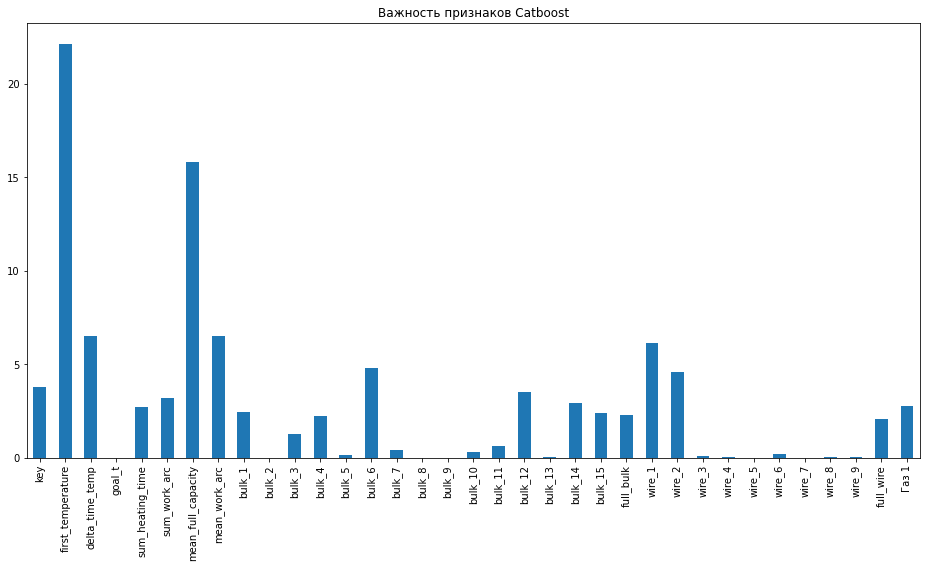

In [180]:
data_total = data_total.set_index('key')

ydata_profiling.ProfileReport(data_total)

Выведем таблицу с сильными корреляциями между признаками:

In [181]:
check = data_total.corr()
check.columns
check[check > 0.6][['sum_heating_time', 'sum_work_arc', 'mean_full_capacity',
       'mean_work_arc', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
       'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'full_bulk', 'wire_1', 'wire_2',
       'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9',
       'full_wire', 'Газ 1']]

,sum_heating_time,sum_work_arc,mean_full_capacity,mean_work_arc,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,full_wire,Газ 1
first_temperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
delta_time_temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goal_t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum_heating_time,1.000000,0.926176,NaN,0.710813,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum_work_arc,0.926176,1.000000,0.636981,0.826374,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_full_capacity,NaN,0.636981,1.000000,0.913159,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_work_arc,0.710813,0.826374,0.913159,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_2,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,0.699342,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Наша таблица и новые связи. Первые 4 столбца убраны, у них нет высоких корреляций.

Но есть пары: mean_work_arc - mean_full_capacity  0.913

wire_8 - bulk_9 0.975

sum_work_arc - sum_heating_time 0.926

Вернемся к выводам позже, после оценки важности признаков.

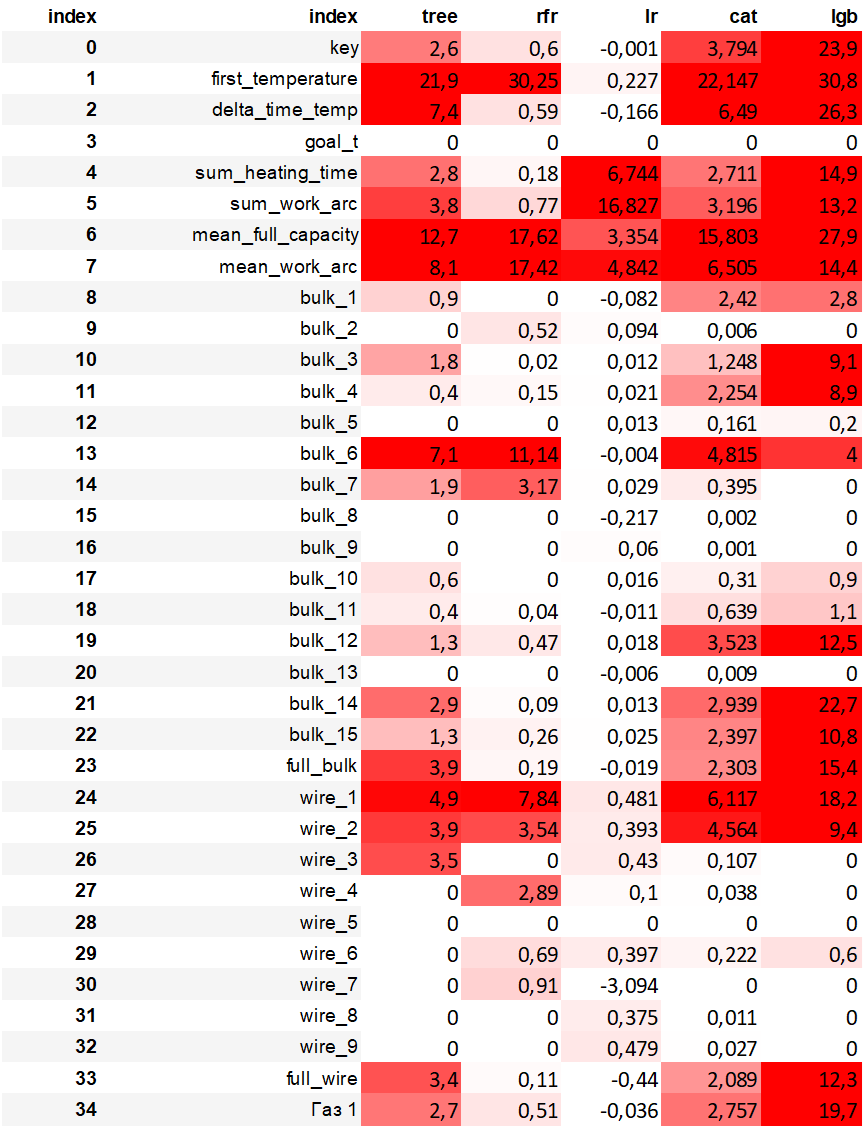

По результатам подбора моделей составлена эта прекрасная таблица важности признаков. 

mean_work_arc проигрывает mean_full_capacity  у всех, кроме линейной регрессии, сделаем отдельный выпуск для линейной регрессии. 

wire_8 важнее, чем bulk_9, последний везде нулевой, удаляем.

важность sum_work_arc выше  sum_heating_time у всех, кроме lgb бустинга. Но разница по lgb бустингу небольшая, всего 1 пункт, удалим sum_heating_time.

Ах да, наша прекрасная переменная goal_t не важна нигде, совсем. А также wire_5, удалим и её.

In [182]:
data_total = data_total.drop(['bulk_9', 'sum_heating_time','goal_t', 'wire_5'], axis = 1)
data_lr = data_total.drop(['mean_full_capacity'], axis = 1)
data_total = data_total.drop(['mean_work_arc'], axis = 1)

Сделано, перейдем к подбору моделей.

**Вывод** Выполнена предобработка и исследовательский анализ данных. 

Обработаны пропуски и выбросы. Заполнены нулями  пропуски в (data_bulk и data_wire, data_wire_time) 

Удалены ковши с пропусками температуры.

Заполнены дополнительные переменные для учета влияния данных и снижения корреляции.  

Объединены таблицы по номеру ковша  key.

Удалены признаки, приводящие к мультиколлинеарности.

## Моделирование

### Подготовка признаков

Подготовим признаки и целевой признак

In [183]:
features = data_total.drop(['temperature'], axis=1)
target = data_total['temperature']

In [184]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [185]:
def rmse(target, predictions):
    error = (target - predictions) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False)


mae_scorer = make_scorer(
    mean_absolute_error, 
    greater_is_better=False)


### Выбор лучшей модели

Первым делом создадим дамми модель:

In [186]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
cross_dm = cross_val_score(dummy_regr, features_train, target_train, cv=5, scoring = rmse_scorer) 
cross_dm.mean()
dummy_predictions_train = dummy_regr.predict(features_train)
dummy_predictions_train 

array([1593.3115693, 1593.3115693, 1593.3115693, ..., 1593.3115693,
       1593.3115693, 1593.3115693])

Сравним с расчетным средним:

In [187]:
target_train.mean()



1593.31156930126

Нужно взглянуть на rmse


In [188]:

rmse_dummy_train = rmse(target_train, dummy_predictions_train)
rmse_dummy_train

11.288533506046441

Наш эталон готов. И судя по RMSE - он не так плох. А мы идём дальше.

### Дерево решений

В наших данных в этот раз нет категориальных переменных, только числа.

In [189]:
best_model = None
best_cross = -rmse_dummy_train
best_depth = 0
for depth in range(1, 25): # Проверялись различные диапазоны, выводы ниже.
    model_tr =  DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth) # модель DecisionTreeRegressor с параметром max_depth=depth
    model_tr.fit(features_train, target_train) 
    predictions_train = model_tr.predict(features_train) 
    cross = cross_val_score(model_tr, features_train, target_train, cv=5, scoring = rmse_scorer)
    if cross.mean()> best_cross:
        best_model = model_tr
        best_cross = cross.mean()
        best_depth = depth

print("RMSE наилучшей модели на обучающей выборке:", -best_cross, "Глубина дерева:", best_depth)

RMSE наилучшей модели на обучающей выборке: 9.537881137298571 Глубина дерева: 6


RMSE наилучшей модели на обучающей выборке: 9.537881137298571 Глубина дерева: 6. 

In [190]:
rmse_tr_train = -best_cross

In [191]:
rmse_tr_test = rmse(target_test,  model_tr.predict(features_test) )
rmse_tr_test

11.209805267433985

И у нас есть первая лучшая модель -  Дерево решений с RMSE наилучшей модели на обучающей выборке: 9.5378  Глубина дерева: 5

Text(0.5, 1.0, 'Важность признаков Случайный лес')

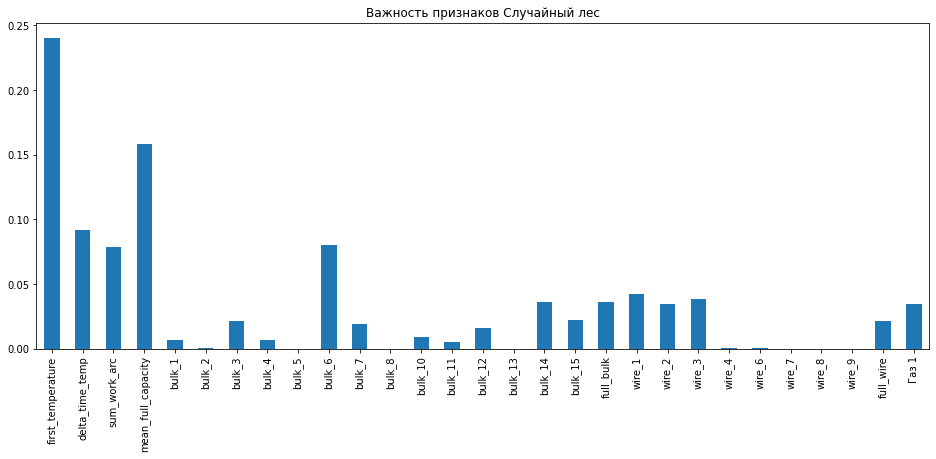

In [192]:
tr_imp = pd.Series(model_tr.feature_importances_,
                         features_train.columns)

tr_imp.plot.bar(figsize=(16,6)).set_title("Важность признаков Случайный лес")


Для модели Дерево решений много важных столбцов - и много неважных. Важны: первоначальная температура, средняя полная мощность, средняя работа электродов, балк 6, время между замерами температуры, wire 1. Любопытно, что общая загрузка веществ, что балка, что проволоки не так важны, как отдельные из них.

Мы используем этот инструмент, вкупе с анализом мультиколлинеарности позволяет избавляться от "балласта". И этот баллст можно исключить и перестроить модель, для модели-победителя!

In [193]:
del_imp = tr_imp.round(3)#[abs(tr_imp)<0.01].round(3)
del_imp.round(2)
del_imp = pd.DataFrame(del_imp)
del_imp.columns = ['tree']
del_imp.reset_index(inplace = True)

In [194]:
del_imp

,index,tree
0,first_temperature,0.240
1,delta_time_temp,0.092
2,sum_work_arc,0.079
3,mean_full_capacity,0.158
4,bulk_1,0.007
5,bulk_2,0.000
6,bulk_3,0.021
7,bulk_4,0.007
8,bulk_5,0.000
9,bulk_6,0.080


### Случайный лес

Поиск велся в широком диапазоне, для сокращения времени при проверке - неужное убираю, сокращая диапазон и увеличивая шаг.

In [195]:
best_model = None
best_est = 0 
best_depth = 0 
best_cross = -rmse_tr_train
best_split = 0
best_leaf = 0
for est in range(30, 32): #был диапазон (1, 101), сокращён до близкого к лучшим значениям
    for depth in range(11,12): #был диапазон (1, 15), сокращён до близкого к лучшим значениям
        for split in range(1,2): #был диапазон (1, 5)
            for leaf in range(1,2): #был диапазон (1, 10)
                model_f = RandomForestRegressor(n_estimators=est, 
                                                max_depth=depth, 
                                                random_state=RANDOM_STATE,  
                                                min_samples_split=split/10,
                                                min_samples_leaf=leaf) 
                model_f.fit(features_train, target_train)
                prediction_f = model_f.predict(features_train)
                cross = cross_val_score(model_f, features_train, target_train, cv=5, scoring = rmse_scorer) 
                if  cross.mean()> best_cross:
                    best_est = est
                    best_depth = depth
                    best_cross = cross.mean()
                    best_split = split
                    best_leaf = leaf
                    best_model = model_f
                    print(cross.mean(), est, depth, split, leaf)
print(best_cross, 'Лучшие гиперпараметры:', best_est,  best_depth, best_split, best_leaf)


-8.982476937137848 30 11 1 1
-8.982476937137848 Лучшие гиперпараметры: 30 11 1 1


8.98354551638865  Лучшие гиперпараметры: 30 11 1 1

Text(0.5, 1.0, 'Важность признаков Случайный лес')

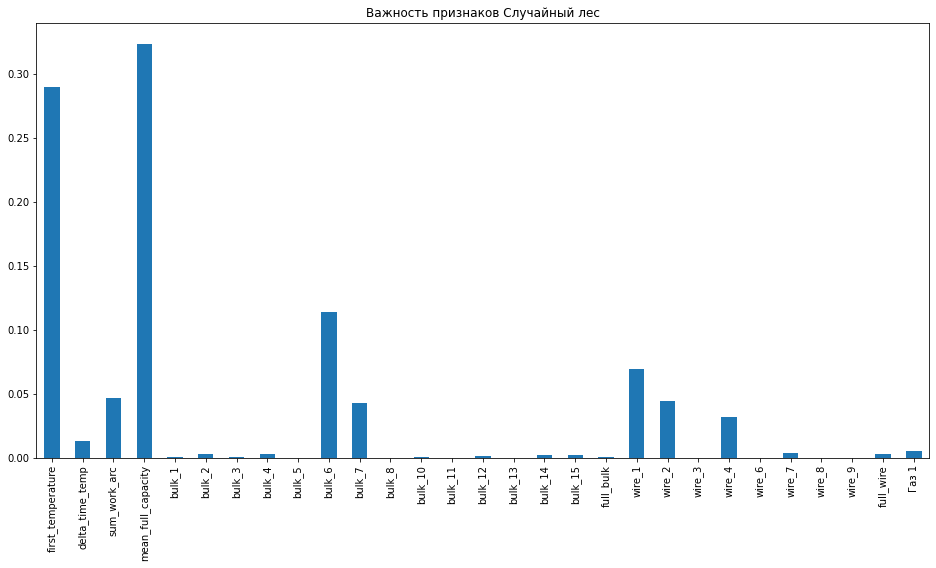

In [196]:
rfr_imp = pd.Series(model_f.feature_importances_,
                         features_train.columns)

rfr_imp.plot.bar(figsize=(16,8)).set_title("Важность признаков Случайный лес")

Для модели Случайный лес важны: первоначальная температура, средняя полная мощность, средняя работа электродов, балк 6, wire 1. Здесь тоже  общая загрузка веществ, что балка, что проволоки не так важны, как отдельные из них. А ещё не считается  время между замерами температуры.

In [197]:
rfr_imp = rfr_imp.round(4)#[abs(rfr_imp)< 0.01].round(3)

rfr_imp = pd.DataFrame(rfr_imp)
rfr_imp.columns = ['rfr']
rfr_imp.reset_index(inplace = True)

In [198]:
rfr_imp

,index,rfr
0,first_temperature,0.2899
1,delta_time_temp,0.0131
2,sum_work_arc,0.0468
3,mean_full_capacity,0.3236
4,bulk_1,0.0006
5,bulk_2,0.0032
6,bulk_3,0.0004
7,bulk_4,0.0025
8,bulk_5,0.0000
9,bulk_6,0.1137


In [199]:
del_imp = del_imp.merge(rfr_imp, on = 'index', how='outer') 
del_imp

,index,tree,rfr
0,first_temperature,0.240,0.2899
1,delta_time_temp,0.092,0.0131
2,sum_work_arc,0.079,0.0468
3,mean_full_capacity,0.158,0.3236
4,bulk_1,0.007,0.0006
5,bulk_2,0.000,0.0032
6,bulk_3,0.021,0.0004
7,bulk_4,0.007,0.0025
8,bulk_5,0.000,0.0000
9,bulk_6,0.080,0.1137


In [200]:
rmse_rf_train = - best_cross
rmse_rf_train

8.982476937137848

у нас новая лучшая модель - Случайный лес с параметрами: best_est - 44, best_depth - 10,  1 1, rmse - 8.92

### Линейная регрессия

Двигаемся дальше, следующая у нас по плану - линейная регрессия. Сперва- классика:

In [201]:
model_l = LinearRegression()


In [202]:
features_lr = data_lr.drop(['temperature'], axis=1)
target_lr = data_lr['temperature']
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(
    features_lr, target_lr, test_size=0.25, random_state=RANDOM_STATE)

In [203]:
model_l = LinearRegression()
model_l.fit(features_train_lr, target_train_lr) # обучим модель на тренировочной выборке

LinearRegression()

In [204]:
rmse_lr_train = - cross_val_score(model_l, features_train_lr, target_train_lr, cv=5, scoring = rmse_scorer).mean()
rmse_lr_train

9.230701604987505

In [205]:
rmse_lr_test = rmse(target_test_lr,  model_l.predict(features_test_lr) )
rmse_lr_test

9.460929154876473

Text(0.5, 1.0, 'Важность признаков Случайный лес')

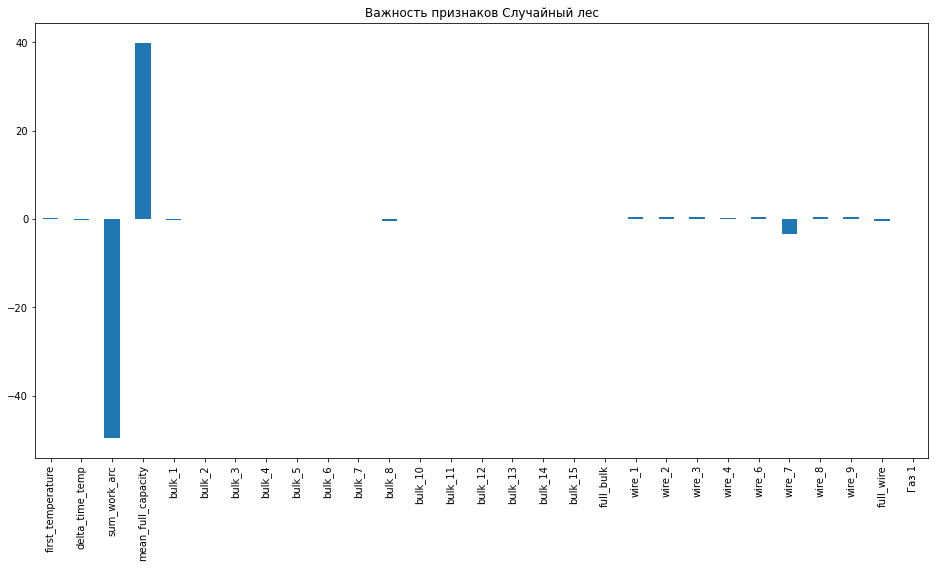

In [206]:
lr_imp = pd.Series(model_l.coef_,
                         features_train.columns)


lr_imp.plot.bar(figsize=(16,8)).set_title("Важность признаков Случайный лес")


Для модели Линейная регрессия на первом месте средняя работа электродов, на втором - суммарное время нагрева, на третьем - средняя полная мощность. Линейная регрессия подходит в лоб - нагревали - получите.

In [207]:

lr_imp = lr_imp.round(3)#[abs(lr_imp)< 0.01].round(3)

lr_imp = pd.DataFrame(lr_imp)
lr_imp.columns = ['lr']
lr_imp.reset_index(inplace = True)


In [208]:
del_imp = del_imp.merge(lr_imp, on = 'index', how='outer') 
del_imp

,index,tree,rfr,lr
0,first_temperature,0.240,0.2899,0.195
1,delta_time_temp,0.092,0.0131,-0.153
2,sum_work_arc,0.079,0.0468,-49.568
3,mean_full_capacity,0.158,0.3236,39.951
4,bulk_1,0.007,0.0006,-0.145
5,bulk_2,0.000,0.0032,0.022
6,bulk_3,0.021,0.0004,-0.063
7,bulk_4,0.007,0.0025,-0.055
8,bulk_5,0.000,0.0000,-0.062
9,bulk_6,0.080,0.1137,-0.080


наш результат на на трэйне у линейной регрессии хуже, RMSE модели линейной регрессии на обучающей выборке : 9.15

### Линейная регрессия ручная SGD 

Может быть, в "ручном" режиме получится лучше? Проверим:

In [209]:

class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size, reg_weight):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_weight = reg_weight
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        
        y = train_target
        w = np.zeros(X.shape[1])
        
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0] # копируем вектор w, чтобы его не менять
                reg = 2 * w.copy()
                reg[0] = 0 
                gradient += self.reg_weight * reg 
                
                w -= self.step_size * gradient

        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0



Чтобы сравнить гребневую регрессию с линейной, начнём с веса регуляризации, равного 0. Затем добавим
обучение с его различными значениями.
проверенные значения [0.0, 0.001, 0.005, 0.1, 1.0, 10.0],[0.0, 1., 1.5, 2., 3., 4] rmse min 51.85  при рег. - 1.0

[0.,0.6, .8, .9, 1.1, 1.2] rmse min 51.82  при рег. - 0.6


In [210]:
scaler=StandardScaler()
scaler.fit(features_train)
features_train_lr = scaler.transform(features_train)
#features_train_lr = scaler.transform(features_test)

In [220]:
regs = [0.,0.6, .8, .9, 1.1, 1.2]#, 0.005, 0.1, 1.0, 10.0]
for reg in regs:
    print("Регуляризация:", reg)
    model_lrh = SGDLinearRegression(0.01, 10, 100, reg)
    model_lrh.fit(features_train_lr, target_train)
    pred_train_lrh = model_lrh.predict(features_train_lr)
    rmse_lrh_train =  rmse(pred_train_lrh, target_train_lr)
    print('RMSE ',rmse_lrh_train)

Регуляризация: 0.0
RMSE  51.86304291157981
Регуляризация: 0.6
RMSE  51.82291194966593
Регуляризация: 0.8
RMSE  51.83861995343319
Регуляризация: 0.9
RMSE  51.84710237850696
Регуляризация: 1.1
RMSE  51.86424595510774
Регуляризация: 1.2
RMSE  51.87270415135375


В любом случае, мы боремся за десятые доли, а нужно на порядок меньше. Переходим к следующему шагу.

Убираем лишние переменные:

In [221]:
del features_train_lr, target_train_lr, features_test_lr, target_test_lr, features_lr, target_lr

In [222]:
rmse_lrh_train = 51.82291

### Градиентный бустинг catboost

In [250]:
model_cat = CatBoostRegressor(random_state=RANDOM_STATE,  loss_function="RMSE", iterations=600)
model_cat.fit(features_train, target_train,verbose=10, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.067731
0:	learn: 11.0760853	total: 4.53ms	remaining: 2.71s
10:	learn: 9.4851003	total: 43.3ms	remaining: 2.32s
20:	learn: 8.6605837	total: 89.1ms	remaining: 2.46s
30:	learn: 8.1293632	total: 130ms	remaining: 2.38s
40:	learn: 7.7918585	total: 175ms	remaining: 2.39s
50:	learn: 7.4690462	total: 225ms	remaining: 2.43s
60:	learn: 7.2066818	total: 282ms	remaining: 2.49s
70:	learn: 6.9904021	total: 331ms	remaining: 2.46s
80:	learn: 6.7688577	total: 382ms	remaining: 2.45s
90:	learn: 6.5805518	total: 435ms	remaining: 2.43s
100:	learn: 6.4289526	total: 474ms	remaining: 2.34s
110:	learn: 6.2655602	total: 520ms	remaining: 2.29s
120:	learn: 6.1169833	total: 557ms	remaining: 2.21s
130:	learn: 5.9901448	total: 599ms	remaining: 2.14s
140:	learn: 5.8514032	total: 643ms	remaining: 2.09s
150:	learn: 5.7260737	total: 684ms	remaining: 2.04s
160:	learn: 5.6066887	total: 736ms	remaining: 2.01s
170:	learn: 5.5127082	total: 776ms	remaining: 1.95s
180:	learn: 5.4135168	total: 815ms	remain

In [251]:
predictions_cat_train = model_cat.predict(features_train)

rmse_cat_train = - cross_val_score(model_cat, features_train, target_train, cv=5, scoring = rmse_scorer).mean()
print("RMSE градиентного бустинга с CatBoost на обучении:", rmse_cat_train)


Learning rate set to 0.065378
0:	learn: 11.3245620	total: 4.45ms	remaining: 2.67s
1:	learn: 11.1524033	total: 8.44ms	remaining: 2.52s
2:	learn: 10.9662081	total: 12.4ms	remaining: 2.47s
3:	learn: 10.7947897	total: 16.8ms	remaining: 2.5s
4:	learn: 10.6269572	total: 20.6ms	remaining: 2.45s
5:	learn: 10.4719423	total: 24.4ms	remaining: 2.42s
6:	learn: 10.3249291	total: 28ms	remaining: 2.37s
7:	learn: 10.1513769	total: 32ms	remaining: 2.37s
8:	learn: 10.0160706	total: 35.9ms	remaining: 2.36s
9:	learn: 9.8890267	total: 39.8ms	remaining: 2.35s
10:	learn: 9.7696812	total: 43.4ms	remaining: 2.32s
11:	learn: 9.6401077	total: 47.3ms	remaining: 2.32s
12:	learn: 9.5350825	total: 53.1ms	remaining: 2.4s
13:	learn: 9.4597446	total: 58.6ms	remaining: 2.45s
14:	learn: 9.3868847	total: 63.5ms	remaining: 2.47s
15:	learn: 9.2882046	total: 67.3ms	remaining: 2.46s
16:	learn: 9.2109510	total: 70.8ms	remaining: 2.43s
17:	learn: 9.1307496	total: 74.4ms	remaining: 2.4s
18:	learn: 9.0491092	total: 78.1ms	remaini

187:	learn: 5.2842112	total: 743ms	remaining: 1.63s
188:	learn: 5.2764135	total: 747ms	remaining: 1.62s
189:	learn: 5.2652097	total: 751ms	remaining: 1.62s
190:	learn: 5.2622881	total: 754ms	remaining: 1.61s
191:	learn: 5.2497745	total: 758ms	remaining: 1.61s
192:	learn: 5.2357732	total: 762ms	remaining: 1.61s
193:	learn: 5.2335384	total: 766ms	remaining: 1.6s
194:	learn: 5.2194593	total: 770ms	remaining: 1.6s
195:	learn: 5.2070834	total: 774ms	remaining: 1.59s
196:	learn: 5.1975878	total: 779ms	remaining: 1.59s
197:	learn: 5.1889872	total: 785ms	remaining: 1.59s
198:	learn: 5.1849224	total: 790ms	remaining: 1.59s
199:	learn: 5.1727723	total: 794ms	remaining: 1.59s
200:	learn: 5.1535895	total: 798ms	remaining: 1.58s
201:	learn: 5.1358385	total: 803ms	remaining: 1.58s
202:	learn: 5.1255226	total: 806ms	remaining: 1.58s
203:	learn: 5.1089886	total: 810ms	remaining: 1.57s
204:	learn: 5.0979741	total: 814ms	remaining: 1.57s
205:	learn: 5.0918896	total: 818ms	remaining: 1.56s
206:	learn: 5.

369:	learn: 3.9609277	total: 1.47s	remaining: 912ms
370:	learn: 3.9578500	total: 1.47s	remaining: 908ms
371:	learn: 3.9516320	total: 1.47s	remaining: 904ms
372:	learn: 3.9453238	total: 1.48s	remaining: 899ms
373:	learn: 3.9409147	total: 1.48s	remaining: 895ms
374:	learn: 3.9404502	total: 1.49s	remaining: 892ms
375:	learn: 3.9375496	total: 1.49s	remaining: 889ms
376:	learn: 3.9305408	total: 1.5s	remaining: 886ms
377:	learn: 3.9279438	total: 1.5s	remaining: 881ms
378:	learn: 3.9245521	total: 1.5s	remaining: 877ms
379:	learn: 3.9153960	total: 1.51s	remaining: 873ms
380:	learn: 3.9104511	total: 1.51s	remaining: 869ms
381:	learn: 3.9060344	total: 1.51s	remaining: 865ms
382:	learn: 3.8995066	total: 1.52s	remaining: 861ms
383:	learn: 3.8941394	total: 1.52s	remaining: 856ms
384:	learn: 3.8840155	total: 1.53s	remaining: 852ms
385:	learn: 3.8752626	total: 1.53s	remaining: 848ms
386:	learn: 3.8743307	total: 1.53s	remaining: 844ms
387:	learn: 3.8684468	total: 1.54s	remaining: 840ms
388:	learn: 3.8

552:	learn: 3.0662844	total: 2.21s	remaining: 188ms
553:	learn: 3.0606765	total: 2.21s	remaining: 184ms
554:	learn: 3.0570238	total: 2.22s	remaining: 180ms
555:	learn: 3.0528559	total: 2.22s	remaining: 176ms
556:	learn: 3.0525846	total: 2.22s	remaining: 172ms
557:	learn: 3.0477356	total: 2.23s	remaining: 168ms
558:	learn: 3.0436201	total: 2.23s	remaining: 164ms
559:	learn: 3.0381758	total: 2.24s	remaining: 160ms
560:	learn: 3.0274860	total: 2.24s	remaining: 156ms
561:	learn: 3.0272378	total: 2.24s	remaining: 152ms
562:	learn: 3.0248210	total: 2.25s	remaining: 148ms
563:	learn: 3.0191549	total: 2.25s	remaining: 144ms
564:	learn: 3.0153042	total: 2.25s	remaining: 140ms
565:	learn: 3.0121762	total: 2.26s	remaining: 136ms
566:	learn: 3.0082730	total: 2.26s	remaining: 132ms
567:	learn: 3.0056206	total: 2.27s	remaining: 128ms
568:	learn: 3.0013095	total: 2.27s	remaining: 124ms
569:	learn: 2.9961830	total: 2.27s	remaining: 120ms
570:	learn: 2.9958127	total: 2.28s	remaining: 116ms
571:	learn: 

142:	learn: 5.6501096	total: 609ms	remaining: 1.95s
143:	learn: 5.6388348	total: 613ms	remaining: 1.94s
144:	learn: 5.6296390	total: 617ms	remaining: 1.94s
145:	learn: 5.6145569	total: 623ms	remaining: 1.94s
146:	learn: 5.6036708	total: 628ms	remaining: 1.94s
147:	learn: 5.5964735	total: 633ms	remaining: 1.93s
148:	learn: 5.5760866	total: 637ms	remaining: 1.93s
149:	learn: 5.5650983	total: 641ms	remaining: 1.92s
150:	learn: 5.5459352	total: 645ms	remaining: 1.92s
151:	learn: 5.5289177	total: 648ms	remaining: 1.91s
152:	learn: 5.5173337	total: 652ms	remaining: 1.9s
153:	learn: 5.5102370	total: 656ms	remaining: 1.9s
154:	learn: 5.4930618	total: 659ms	remaining: 1.89s
155:	learn: 5.4812284	total: 663ms	remaining: 1.89s
156:	learn: 5.4743739	total: 667ms	remaining: 1.88s
157:	learn: 5.4683148	total: 670ms	remaining: 1.88s
158:	learn: 5.4516393	total: 674ms	remaining: 1.87s
159:	learn: 5.4338592	total: 678ms	remaining: 1.86s
160:	learn: 5.4196389	total: 682ms	remaining: 1.86s
161:	learn: 5.

320:	learn: 4.0902788	total: 1.35s	remaining: 1.17s
321:	learn: 4.0868357	total: 1.36s	remaining: 1.17s
322:	learn: 4.0759969	total: 1.36s	remaining: 1.17s
323:	learn: 4.0713799	total: 1.36s	remaining: 1.16s
324:	learn: 4.0656599	total: 1.37s	remaining: 1.16s
325:	learn: 4.0619632	total: 1.37s	remaining: 1.16s
326:	learn: 4.0581818	total: 1.38s	remaining: 1.15s
327:	learn: 4.0481254	total: 1.38s	remaining: 1.15s
328:	learn: 4.0475135	total: 1.39s	remaining: 1.14s
329:	learn: 4.0470012	total: 1.39s	remaining: 1.14s
330:	learn: 4.0465066	total: 1.4s	remaining: 1.13s
331:	learn: 4.0457669	total: 1.4s	remaining: 1.13s
332:	learn: 4.0413441	total: 1.4s	remaining: 1.13s
333:	learn: 4.0342337	total: 1.41s	remaining: 1.12s
334:	learn: 4.0313294	total: 1.41s	remaining: 1.12s
335:	learn: 4.0241159	total: 1.42s	remaining: 1.11s
336:	learn: 4.0176197	total: 1.42s	remaining: 1.11s
337:	learn: 4.0130814	total: 1.42s	remaining: 1.1s
338:	learn: 4.0051103	total: 1.43s	remaining: 1.1s
339:	learn: 4.002

498:	learn: 3.2720494	total: 2.08s	remaining: 421ms
499:	learn: 3.2705175	total: 2.08s	remaining: 417ms
500:	learn: 3.2650477	total: 2.09s	remaining: 412ms
501:	learn: 3.2646077	total: 2.09s	remaining: 408ms
502:	learn: 3.2607396	total: 2.09s	remaining: 404ms
503:	learn: 3.2532812	total: 2.1s	remaining: 400ms
504:	learn: 3.2485958	total: 2.1s	remaining: 395ms
505:	learn: 3.2456908	total: 2.11s	remaining: 391ms
506:	learn: 3.2441100	total: 2.11s	remaining: 387ms
507:	learn: 3.2350553	total: 2.11s	remaining: 383ms
508:	learn: 3.2314334	total: 2.12s	remaining: 379ms
509:	learn: 3.2311804	total: 2.12s	remaining: 374ms
510:	learn: 3.2287179	total: 2.13s	remaining: 370ms
511:	learn: 3.2271821	total: 2.13s	remaining: 366ms
512:	learn: 3.2240197	total: 2.13s	remaining: 362ms
513:	learn: 3.2223310	total: 2.14s	remaining: 358ms
514:	learn: 3.2163329	total: 2.14s	remaining: 354ms
515:	learn: 3.2109098	total: 2.15s	remaining: 350ms
516:	learn: 3.2106994	total: 2.15s	remaining: 345ms
517:	learn: 3.

86:	learn: 6.6740089	total: 421ms	remaining: 2.48s
87:	learn: 6.6600277	total: 425ms	remaining: 2.47s
88:	learn: 6.6507341	total: 429ms	remaining: 2.46s
89:	learn: 6.6340285	total: 434ms	remaining: 2.46s
90:	learn: 6.6169937	total: 440ms	remaining: 2.46s
91:	learn: 6.6019821	total: 445ms	remaining: 2.46s
92:	learn: 6.5703288	total: 451ms	remaining: 2.46s
93:	learn: 6.5456515	total: 455ms	remaining: 2.45s
94:	learn: 6.5271553	total: 459ms	remaining: 2.44s
95:	learn: 6.5197177	total: 463ms	remaining: 2.43s
96:	learn: 6.5025033	total: 467ms	remaining: 2.42s
97:	learn: 6.4735513	total: 472ms	remaining: 2.42s
98:	learn: 6.4543223	total: 478ms	remaining: 2.42s
99:	learn: 6.4349454	total: 482ms	remaining: 2.41s
100:	learn: 6.4226093	total: 486ms	remaining: 2.4s
101:	learn: 6.4102739	total: 489ms	remaining: 2.39s
102:	learn: 6.3970663	total: 492ms	remaining: 2.38s
103:	learn: 6.3734817	total: 496ms	remaining: 2.37s
104:	learn: 6.3475202	total: 500ms	remaining: 2.35s
105:	learn: 6.3223095	total

272:	learn: 4.5171389	total: 1.16s	remaining: 1.39s
273:	learn: 4.5083966	total: 1.16s	remaining: 1.38s
274:	learn: 4.5076303	total: 1.17s	remaining: 1.38s
275:	learn: 4.4987208	total: 1.17s	remaining: 1.37s
276:	learn: 4.4943285	total: 1.18s	remaining: 1.37s
277:	learn: 4.4931832	total: 1.18s	remaining: 1.37s
278:	learn: 4.4914335	total: 1.19s	remaining: 1.37s
279:	learn: 4.4750585	total: 1.19s	remaining: 1.36s
280:	learn: 4.4678261	total: 1.2s	remaining: 1.36s
281:	learn: 4.4671405	total: 1.21s	remaining: 1.36s
282:	learn: 4.4633568	total: 1.21s	remaining: 1.35s
283:	learn: 4.4575183	total: 1.21s	remaining: 1.35s
284:	learn: 4.4484253	total: 1.22s	remaining: 1.35s
285:	learn: 4.4393938	total: 1.22s	remaining: 1.34s
286:	learn: 4.4317303	total: 1.23s	remaining: 1.34s
287:	learn: 4.4226273	total: 1.24s	remaining: 1.34s
288:	learn: 4.4159065	total: 1.24s	remaining: 1.34s
289:	learn: 4.4065083	total: 1.25s	remaining: 1.33s
290:	learn: 4.3977854	total: 1.25s	remaining: 1.33s
291:	learn: 4

438:	learn: 3.5207881	total: 1.89s	remaining: 693ms
439:	learn: 3.5163270	total: 1.9s	remaining: 690ms
440:	learn: 3.5082259	total: 1.9s	remaining: 687ms
441:	learn: 3.4990032	total: 1.91s	remaining: 684ms
442:	learn: 3.4917107	total: 1.92s	remaining: 680ms
443:	learn: 3.4879620	total: 1.92s	remaining: 676ms
444:	learn: 3.4849363	total: 1.93s	remaining: 672ms
445:	learn: 3.4814759	total: 1.93s	remaining: 667ms
446:	learn: 3.4751903	total: 1.94s	remaining: 663ms
447:	learn: 3.4702473	total: 1.94s	remaining: 658ms
448:	learn: 3.4653669	total: 1.94s	remaining: 654ms
449:	learn: 3.4614408	total: 1.95s	remaining: 649ms
450:	learn: 3.4513988	total: 1.95s	remaining: 645ms
451:	learn: 3.4471601	total: 1.95s	remaining: 640ms
452:	learn: 3.4401833	total: 1.96s	remaining: 636ms
453:	learn: 3.4338280	total: 1.96s	remaining: 631ms
454:	learn: 3.4281478	total: 1.97s	remaining: 627ms
455:	learn: 3.4231600	total: 1.97s	remaining: 622ms
456:	learn: 3.4226630	total: 1.97s	remaining: 618ms
457:	learn: 3.

Learning rate set to 0.065386
0:	learn: 11.2104484	total: 4.73ms	remaining: 2.84s
1:	learn: 11.0217707	total: 8.84ms	remaining: 2.64s
2:	learn: 10.8509507	total: 14.2ms	remaining: 2.83s
3:	learn: 10.6841683	total: 18.6ms	remaining: 2.78s
4:	learn: 10.5387788	total: 23.2ms	remaining: 2.76s
5:	learn: 10.3712346	total: 27.4ms	remaining: 2.71s
6:	learn: 10.2282516	total: 31.2ms	remaining: 2.64s
7:	learn: 10.1093354	total: 35.1ms	remaining: 2.59s
8:	learn: 9.9778155	total: 38.9ms	remaining: 2.55s
9:	learn: 9.8517835	total: 42.9ms	remaining: 2.53s
10:	learn: 9.7165021	total: 46.9ms	remaining: 2.51s
11:	learn: 9.6129282	total: 52.3ms	remaining: 2.56s
12:	learn: 9.5260667	total: 57.9ms	remaining: 2.61s
13:	learn: 9.4446769	total: 63.8ms	remaining: 2.67s
14:	learn: 9.3554476	total: 70.1ms	remaining: 2.73s
15:	learn: 9.2771643	total: 76.1ms	remaining: 2.78s
16:	learn: 9.1885222	total: 82.3ms	remaining: 2.82s
17:	learn: 9.1136483	total: 88ms	remaining: 2.84s
18:	learn: 9.0462743	total: 92.6ms	rem

183:	learn: 5.2989702	total: 761ms	remaining: 1.72s
184:	learn: 5.2914040	total: 767ms	remaining: 1.72s
185:	learn: 5.2780123	total: 771ms	remaining: 1.72s
186:	learn: 5.2647960	total: 775ms	remaining: 1.71s
187:	learn: 5.2540333	total: 778ms	remaining: 1.71s
188:	learn: 5.2448354	total: 782ms	remaining: 1.7s
189:	learn: 5.2389929	total: 786ms	remaining: 1.7s
190:	learn: 5.2249732	total: 790ms	remaining: 1.69s
191:	learn: 5.2226862	total: 791ms	remaining: 1.68s
192:	learn: 5.2127704	total: 795ms	remaining: 1.68s
193:	learn: 5.1909900	total: 798ms	remaining: 1.67s
194:	learn: 5.1859382	total: 802ms	remaining: 1.67s
195:	learn: 5.1706577	total: 806ms	remaining: 1.66s
196:	learn: 5.1583200	total: 809ms	remaining: 1.66s
197:	learn: 5.1464659	total: 813ms	remaining: 1.65s
198:	learn: 5.1419679	total: 816ms	remaining: 1.65s
199:	learn: 5.1257643	total: 820ms	remaining: 1.64s
200:	learn: 5.1107415	total: 823ms	remaining: 1.63s
201:	learn: 5.1055494	total: 827ms	remaining: 1.63s
202:	learn: 5.

359:	learn: 3.9654126	total: 1.49s	remaining: 993ms
360:	learn: 3.9608361	total: 1.49s	remaining: 989ms
361:	learn: 3.9590257	total: 1.5s	remaining: 984ms
362:	learn: 3.9551284	total: 1.5s	remaining: 980ms
363:	learn: 3.9514021	total: 1.5s	remaining: 976ms
364:	learn: 3.9478672	total: 1.51s	remaining: 971ms
365:	learn: 3.9450697	total: 1.51s	remaining: 967ms
366:	learn: 3.9387579	total: 1.51s	remaining: 962ms
367:	learn: 3.9324964	total: 1.52s	remaining: 958ms
368:	learn: 3.9291867	total: 1.52s	remaining: 953ms
369:	learn: 3.9187131	total: 1.53s	remaining: 949ms
370:	learn: 3.9181534	total: 1.53s	remaining: 944ms
371:	learn: 3.9093364	total: 1.53s	remaining: 940ms
372:	learn: 3.9014422	total: 1.54s	remaining: 936ms
373:	learn: 3.8983757	total: 1.54s	remaining: 931ms
374:	learn: 3.8899592	total: 1.54s	remaining: 927ms
375:	learn: 3.8846777	total: 1.55s	remaining: 922ms
376:	learn: 3.8735239	total: 1.55s	remaining: 918ms
377:	learn: 3.8648619	total: 1.55s	remaining: 913ms
378:	learn: 3.8

532:	learn: 3.1304766	total: 2.21s	remaining: 278ms
533:	learn: 3.1238747	total: 2.21s	remaining: 273ms
534:	learn: 3.1217811	total: 2.22s	remaining: 269ms
535:	learn: 3.1191832	total: 2.22s	remaining: 265ms
536:	learn: 3.1159649	total: 2.22s	remaining: 261ms
537:	learn: 3.1154514	total: 2.23s	remaining: 257ms
538:	learn: 3.1100281	total: 2.23s	remaining: 252ms
539:	learn: 3.1036927	total: 2.23s	remaining: 248ms
540:	learn: 3.1001771	total: 2.24s	remaining: 244ms
541:	learn: 3.0936667	total: 2.24s	remaining: 240ms
542:	learn: 3.0910345	total: 2.25s	remaining: 236ms
543:	learn: 3.0841357	total: 2.25s	remaining: 232ms
544:	learn: 3.0780621	total: 2.25s	remaining: 227ms
545:	learn: 3.0739018	total: 2.26s	remaining: 223ms
546:	learn: 3.0735884	total: 2.26s	remaining: 219ms
547:	learn: 3.0687646	total: 2.27s	remaining: 215ms
548:	learn: 3.0636120	total: 2.27s	remaining: 211ms
549:	learn: 3.0596051	total: 2.28s	remaining: 207ms
550:	learn: 3.0565436	total: 2.28s	remaining: 203ms
551:	learn: 

93:	learn: 6.4945444	total: 411ms	remaining: 2.21s
94:	learn: 6.4718748	total: 415ms	remaining: 2.21s
95:	learn: 6.4497764	total: 419ms	remaining: 2.2s
96:	learn: 6.4355712	total: 424ms	remaining: 2.2s
97:	learn: 6.4132560	total: 428ms	remaining: 2.19s
98:	learn: 6.3871367	total: 432ms	remaining: 2.18s
99:	learn: 6.3659163	total: 435ms	remaining: 2.18s
100:	learn: 6.3360994	total: 439ms	remaining: 2.17s
101:	learn: 6.3248188	total: 443ms	remaining: 2.16s
102:	learn: 6.3125563	total: 447ms	remaining: 2.16s
103:	learn: 6.3013586	total: 451ms	remaining: 2.15s
104:	learn: 6.2821588	total: 455ms	remaining: 2.14s
105:	learn: 6.2632022	total: 458ms	remaining: 2.14s
106:	learn: 6.2367408	total: 462ms	remaining: 2.13s
107:	learn: 6.2231047	total: 466ms	remaining: 2.12s
108:	learn: 6.2002194	total: 473ms	remaining: 2.13s
109:	learn: 6.1874439	total: 480ms	remaining: 2.14s
110:	learn: 6.1639080	total: 486ms	remaining: 2.14s
111:	learn: 6.1449149	total: 492ms	remaining: 2.15s
112:	learn: 6.1190488

268:	learn: 4.2992328	total: 1.14s	remaining: 1.4s
269:	learn: 4.2944909	total: 1.14s	remaining: 1.4s
270:	learn: 4.2917140	total: 1.15s	remaining: 1.39s
271:	learn: 4.2871385	total: 1.15s	remaining: 1.39s
272:	learn: 4.2811762	total: 1.16s	remaining: 1.38s
273:	learn: 4.2705429	total: 1.16s	remaining: 1.38s
274:	learn: 4.2636534	total: 1.16s	remaining: 1.37s
275:	learn: 4.2501891	total: 1.17s	remaining: 1.37s
276:	learn: 4.2374800	total: 1.17s	remaining: 1.36s
277:	learn: 4.2277583	total: 1.17s	remaining: 1.36s
278:	learn: 4.2249590	total: 1.18s	remaining: 1.35s
279:	learn: 4.2186120	total: 1.18s	remaining: 1.35s
280:	learn: 4.2091777	total: 1.19s	remaining: 1.35s
281:	learn: 4.1992329	total: 1.19s	remaining: 1.35s
282:	learn: 4.1959205	total: 1.2s	remaining: 1.34s
283:	learn: 4.1900656	total: 1.2s	remaining: 1.34s
284:	learn: 4.1804786	total: 1.21s	remaining: 1.33s
285:	learn: 4.1694446	total: 1.21s	remaining: 1.33s
286:	learn: 4.1658441	total: 1.21s	remaining: 1.32s
287:	learn: 4.15

450:	learn: 3.2865171	total: 1.86s	remaining: 616ms
451:	learn: 3.2824148	total: 1.87s	remaining: 612ms
452:	learn: 3.2783710	total: 1.87s	remaining: 608ms
453:	learn: 3.2761266	total: 1.88s	remaining: 603ms
454:	learn: 3.2757317	total: 1.88s	remaining: 599ms
455:	learn: 3.2697797	total: 1.88s	remaining: 595ms
456:	learn: 3.2658352	total: 1.89s	remaining: 591ms
457:	learn: 3.2630628	total: 1.89s	remaining: 587ms
458:	learn: 3.2553563	total: 1.9s	remaining: 583ms
459:	learn: 3.2545538	total: 1.9s	remaining: 579ms
460:	learn: 3.2511258	total: 1.91s	remaining: 575ms
461:	learn: 3.2472329	total: 1.91s	remaining: 572ms
462:	learn: 3.2438939	total: 1.92s	remaining: 568ms
463:	learn: 3.2399507	total: 1.92s	remaining: 563ms
464:	learn: 3.2327116	total: 1.93s	remaining: 559ms
465:	learn: 3.2269319	total: 1.93s	remaining: 555ms
466:	learn: 3.2230069	total: 1.93s	remaining: 551ms
467:	learn: 3.2171041	total: 1.94s	remaining: 546ms
468:	learn: 3.2137974	total: 1.94s	remaining: 542ms
469:	learn: 3.

In [225]:
model_cat_mae = CatBoostRegressor(random_state=RANDOM_STATE,  loss_function="MAE", iterations=700)
model_cat_mae.fit(features_train, target_train,verbose=10, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.0519177	total: 4.68ms	remaining: 3.27s
10:	learn: 7.4976402	total: 44.5ms	remaining: 2.79s
20:	learn: 7.0520667	total: 87.7ms	remaining: 2.83s
30:	learn: 6.6894472	total: 139ms	remaining: 2.99s
40:	learn: 6.4153853	total: 190ms	remaining: 3.05s
50:	learn: 6.1962946	total: 230ms	remaining: 2.92s
60:	learn: 5.9986625	total: 282ms	remaining: 2.95s
70:	learn: 5.8148537	total: 344ms	remaining: 3.05s
80:	learn: 5.6692258	total: 399ms	remaining: 3.05s
90:	learn: 5.5234284	total: 463ms	remaining: 3.1s
100:	learn: 5.4233313	total: 529ms	remaining: 3.14s
110:	learn: 5.3254718	total: 593ms	remaining: 3.15s
120:	learn: 5.2283870	total: 648ms	remaining: 3.1s
130:	learn: 5.1474356	total: 696ms	remaining: 3.02s
140:	learn: 5.0708456	total: 735ms	remaining: 2.92s
150:	learn: 4.9934322	total: 799ms	remaining: 2.91s
160:	learn: 4.9294049	total: 863ms	remaining: 2.89s
170:	learn: 4.8773534	total: 928ms	remaining: 2.87s
180:	learn: 4.8159492	total: 989ms	remaining: 2.83s
190:	learn: 4.7517587	

In [226]:
predictions_cat_train_mae = model_cat_mae.predict(features_train)

cat_train_mae = - cross_val_score(model_cat_mae, features_train, target_train, cv=5, scoring = mae_scorer).mean()
print("MAE градиентного бустинга с CatBoost на обучении:", cat_train_mae)


0:	learn: 8.1577784	total: 4.11ms	remaining: 2.87s
1:	learn: 8.0900184	total: 8.21ms	remaining: 2.86s
2:	learn: 8.0412277	total: 12.3ms	remaining: 2.86s
3:	learn: 7.9689472	total: 16.9ms	remaining: 2.94s
4:	learn: 7.9157053	total: 21.7ms	remaining: 3.02s
5:	learn: 7.8851360	total: 25.3ms	remaining: 2.93s
6:	learn: 7.8378227	total: 29ms	remaining: 2.87s
7:	learn: 7.7683381	total: 33.1ms	remaining: 2.86s
8:	learn: 7.7022395	total: 38.2ms	remaining: 2.94s
9:	learn: 7.6399318	total: 44.9ms	remaining: 3.1s
10:	learn: 7.5787537	total: 51.3ms	remaining: 3.21s
11:	learn: 7.5401167	total: 58.1ms	remaining: 3.33s
12:	learn: 7.4976503	total: 64.4ms	remaining: 3.4s
13:	learn: 7.4579958	total: 70.8ms	remaining: 3.47s
14:	learn: 7.4004015	total: 77.2ms	remaining: 3.52s
15:	learn: 7.3384634	total: 83.6ms	remaining: 3.58s
16:	learn: 7.2937723	total: 90.1ms	remaining: 3.62s
17:	learn: 7.2468927	total: 96.5ms	remaining: 3.65s
18:	learn: 7.2200656	total: 103ms	remaining: 3.67s
19:	learn: 7.1907718	total:

160:	learn: 4.8979347	total: 736ms	remaining: 2.46s
161:	learn: 4.8917078	total: 740ms	remaining: 2.46s
162:	learn: 4.8865277	total: 743ms	remaining: 2.45s
163:	learn: 4.8821892	total: 747ms	remaining: 2.44s
164:	learn: 4.8744501	total: 750ms	remaining: 2.43s
165:	learn: 4.8643751	total: 754ms	remaining: 2.42s
166:	learn: 4.8599804	total: 757ms	remaining: 2.42s
167:	learn: 4.8553213	total: 761ms	remaining: 2.41s
168:	learn: 4.8502292	total: 764ms	remaining: 2.4s
169:	learn: 4.8429916	total: 768ms	remaining: 2.39s
170:	learn: 4.8330258	total: 772ms	remaining: 2.39s
171:	learn: 4.8302114	total: 775ms	remaining: 2.38s
172:	learn: 4.8223825	total: 779ms	remaining: 2.37s
173:	learn: 4.8158614	total: 783ms	remaining: 2.37s
174:	learn: 4.8093636	total: 789ms	remaining: 2.37s
175:	learn: 4.8038637	total: 795ms	remaining: 2.37s
176:	learn: 4.7958247	total: 801ms	remaining: 2.37s
177:	learn: 4.7875453	total: 808ms	remaining: 2.37s
178:	learn: 4.7797393	total: 814ms	remaining: 2.37s
179:	learn: 4

320:	learn: 3.9997572	total: 1.47s	remaining: 1.73s
321:	learn: 3.9958691	total: 1.47s	remaining: 1.73s
322:	learn: 3.9924026	total: 1.48s	remaining: 1.72s
323:	learn: 3.9900445	total: 1.48s	remaining: 1.72s
324:	learn: 3.9826267	total: 1.48s	remaining: 1.71s
325:	learn: 3.9799118	total: 1.49s	remaining: 1.7s
326:	learn: 3.9781452	total: 1.49s	remaining: 1.7s
327:	learn: 3.9731963	total: 1.49s	remaining: 1.69s
328:	learn: 3.9696454	total: 1.5s	remaining: 1.69s
329:	learn: 3.9663525	total: 1.5s	remaining: 1.68s
330:	learn: 3.9610367	total: 1.5s	remaining: 1.68s
331:	learn: 3.9529208	total: 1.51s	remaining: 1.67s
332:	learn: 3.9482218	total: 1.51s	remaining: 1.67s
333:	learn: 3.9447127	total: 1.52s	remaining: 1.66s
334:	learn: 3.9415397	total: 1.52s	remaining: 1.66s
335:	learn: 3.9386815	total: 1.53s	remaining: 1.66s
336:	learn: 3.9335494	total: 1.53s	remaining: 1.65s
337:	learn: 3.9288922	total: 1.54s	remaining: 1.65s
338:	learn: 3.9236547	total: 1.55s	remaining: 1.65s
339:	learn: 3.917

502:	learn: 3.3907503	total: 2.39s	remaining: 936ms
503:	learn: 3.3879638	total: 2.4s	remaining: 932ms
504:	learn: 3.3861876	total: 2.4s	remaining: 928ms
505:	learn: 3.3835386	total: 2.41s	remaining: 924ms
506:	learn: 3.3820605	total: 2.42s	remaining: 920ms
507:	learn: 3.3779239	total: 2.42s	remaining: 916ms
508:	learn: 3.3760159	total: 2.43s	remaining: 912ms
509:	learn: 3.3745051	total: 2.44s	remaining: 907ms
510:	learn: 3.3718425	total: 2.44s	remaining: 903ms
511:	learn: 3.3697148	total: 2.45s	remaining: 899ms
512:	learn: 3.3691042	total: 2.46s	remaining: 895ms
513:	learn: 3.3680455	total: 2.46s	remaining: 891ms
514:	learn: 3.3655033	total: 2.47s	remaining: 887ms
515:	learn: 3.3632708	total: 2.47s	remaining: 883ms
516:	learn: 3.3613459	total: 2.48s	remaining: 878ms
517:	learn: 3.3588677	total: 2.49s	remaining: 874ms
518:	learn: 3.3560422	total: 2.49s	remaining: 870ms
519:	learn: 3.3534215	total: 2.5s	remaining: 866ms
520:	learn: 3.3490878	total: 2.51s	remaining: 861ms
521:	learn: 3.3

692:	learn: 2.9991430	total: 3.31s	remaining: 33.5ms
693:	learn: 2.9978956	total: 3.31s	remaining: 28.7ms
694:	learn: 2.9959240	total: 3.32s	remaining: 23.9ms
695:	learn: 2.9950106	total: 3.33s	remaining: 19.1ms
696:	learn: 2.9939956	total: 3.33s	remaining: 14.3ms
697:	learn: 2.9922472	total: 3.34s	remaining: 9.56ms
698:	learn: 2.9911507	total: 3.34s	remaining: 4.78ms
699:	learn: 2.9899287	total: 3.35s	remaining: 0us
0:	learn: 7.8871501	total: 4.24ms	remaining: 2.96s
1:	learn: 7.8354021	total: 8.49ms	remaining: 2.96s
2:	learn: 7.7844270	total: 12.3ms	remaining: 2.85s
3:	learn: 7.7534498	total: 16ms	remaining: 2.78s
4:	learn: 7.7029898	total: 19.9ms	remaining: 2.76s
5:	learn: 7.6415778	total: 24.3ms	remaining: 2.82s
6:	learn: 7.5943313	total: 29.6ms	remaining: 2.92s
7:	learn: 7.5390611	total: 33.4ms	remaining: 2.89s
8:	learn: 7.4884048	total: 37.2ms	remaining: 2.86s
9:	learn: 7.4427742	total: 41.1ms	remaining: 2.84s
10:	learn: 7.3989472	total: 45.1ms	remaining: 2.83s
11:	learn: 7.332318

166:	learn: 4.7867064	total: 745ms	remaining: 2.38s
167:	learn: 4.7799056	total: 748ms	remaining: 2.37s
168:	learn: 4.7732034	total: 752ms	remaining: 2.36s
169:	learn: 4.7630581	total: 755ms	remaining: 2.35s
170:	learn: 4.7571765	total: 759ms	remaining: 2.35s
171:	learn: 4.7468205	total: 763ms	remaining: 2.34s
172:	learn: 4.7392573	total: 767ms	remaining: 2.33s
173:	learn: 4.7348540	total: 770ms	remaining: 2.33s
174:	learn: 4.7303281	total: 774ms	remaining: 2.32s
175:	learn: 4.7246721	total: 780ms	remaining: 2.32s
176:	learn: 4.7179586	total: 786ms	remaining: 2.32s
177:	learn: 4.7123488	total: 790ms	remaining: 2.32s
178:	learn: 4.7019557	total: 794ms	remaining: 2.31s
179:	learn: 4.6971931	total: 798ms	remaining: 2.3s
180:	learn: 4.6923641	total: 801ms	remaining: 2.3s
181:	learn: 4.6874496	total: 805ms	remaining: 2.29s
182:	learn: 4.6798501	total: 809ms	remaining: 2.28s
183:	learn: 4.6754656	total: 812ms	remaining: 2.28s
184:	learn: 4.6692891	total: 816ms	remaining: 2.27s
185:	learn: 4.

328:	learn: 3.8787930	total: 1.48s	remaining: 1.67s
329:	learn: 3.8728353	total: 1.49s	remaining: 1.67s
330:	learn: 3.8666574	total: 1.5s	remaining: 1.67s
331:	learn: 3.8621123	total: 1.5s	remaining: 1.67s
332:	learn: 3.8556082	total: 1.51s	remaining: 1.66s
333:	learn: 3.8483212	total: 1.51s	remaining: 1.66s
334:	learn: 3.8432159	total: 1.52s	remaining: 1.66s
335:	learn: 3.8367351	total: 1.53s	remaining: 1.66s
336:	learn: 3.8295404	total: 1.53s	remaining: 1.65s
337:	learn: 3.8250370	total: 1.54s	remaining: 1.65s
338:	learn: 3.8216869	total: 1.55s	remaining: 1.65s
339:	learn: 3.8182666	total: 1.55s	remaining: 1.64s
340:	learn: 3.8130993	total: 1.56s	remaining: 1.64s
341:	learn: 3.8053151	total: 1.56s	remaining: 1.63s
342:	learn: 3.8010731	total: 1.57s	remaining: 1.63s
343:	learn: 3.7974020	total: 1.57s	remaining: 1.63s
344:	learn: 3.7912131	total: 1.58s	remaining: 1.62s
345:	learn: 3.7889639	total: 1.58s	remaining: 1.62s
346:	learn: 3.7866213	total: 1.59s	remaining: 1.62s
347:	learn: 3.

492:	learn: 3.3080743	total: 2.4s	remaining: 1.01s
493:	learn: 3.3058540	total: 2.41s	remaining: 1s
494:	learn: 3.3031698	total: 2.41s	remaining: 1000ms
495:	learn: 3.3020195	total: 2.42s	remaining: 995ms
496:	learn: 3.2974396	total: 2.42s	remaining: 991ms
497:	learn: 3.2959168	total: 2.43s	remaining: 987ms
498:	learn: 3.2928111	total: 2.44s	remaining: 982ms
499:	learn: 3.2903269	total: 2.44s	remaining: 978ms
500:	learn: 3.2890015	total: 2.45s	remaining: 973ms
501:	learn: 3.2865606	total: 2.45s	remaining: 968ms
502:	learn: 3.2849360	total: 2.46s	remaining: 964ms
503:	learn: 3.2832459	total: 2.46s	remaining: 959ms
504:	learn: 3.2788512	total: 2.47s	remaining: 954ms
505:	learn: 3.2776980	total: 2.48s	remaining: 950ms
506:	learn: 3.2746670	total: 2.48s	remaining: 945ms
507:	learn: 3.2707002	total: 2.49s	remaining: 941ms
508:	learn: 3.2691540	total: 2.49s	remaining: 936ms
509:	learn: 3.2677139	total: 2.5s	remaining: 931ms
510:	learn: 3.2668716	total: 2.5s	remaining: 927ms
511:	learn: 3.264

657:	learn: 2.9677027	total: 3.13s	remaining: 200ms
658:	learn: 2.9656587	total: 3.13s	remaining: 195ms
659:	learn: 2.9650562	total: 3.14s	remaining: 190ms
660:	learn: 2.9631638	total: 3.14s	remaining: 185ms
661:	learn: 2.9619884	total: 3.15s	remaining: 181ms
662:	learn: 2.9608297	total: 3.16s	remaining: 176ms
663:	learn: 2.9599414	total: 3.16s	remaining: 171ms
664:	learn: 2.9584245	total: 3.17s	remaining: 167ms
665:	learn: 2.9566254	total: 3.17s	remaining: 162ms
666:	learn: 2.9563666	total: 3.17s	remaining: 157ms
667:	learn: 2.9536974	total: 3.18s	remaining: 152ms
668:	learn: 2.9503176	total: 3.18s	remaining: 147ms
669:	learn: 2.9486614	total: 3.18s	remaining: 143ms
670:	learn: 2.9475640	total: 3.19s	remaining: 138ms
671:	learn: 2.9461148	total: 3.19s	remaining: 133ms
672:	learn: 2.9422008	total: 3.2s	remaining: 128ms
673:	learn: 2.9408127	total: 3.2s	remaining: 123ms
674:	learn: 2.9392699	total: 3.2s	remaining: 119ms
675:	learn: 2.9381896	total: 3.21s	remaining: 114ms
676:	learn: 2.9

127:	learn: 5.0993948	total: 563ms	remaining: 2.52s
128:	learn: 5.0888785	total: 567ms	remaining: 2.51s
129:	learn: 5.0823847	total: 571ms	remaining: 2.5s
130:	learn: 5.0720756	total: 575ms	remaining: 2.5s
131:	learn: 5.0640197	total: 579ms	remaining: 2.49s
132:	learn: 5.0516209	total: 583ms	remaining: 2.48s
133:	learn: 5.0364925	total: 587ms	remaining: 2.48s
134:	learn: 5.0265462	total: 591ms	remaining: 2.47s
135:	learn: 5.0178444	total: 594ms	remaining: 2.46s
136:	learn: 5.0061866	total: 598ms	remaining: 2.46s
137:	learn: 4.9952076	total: 602ms	remaining: 2.45s
138:	learn: 4.9815256	total: 606ms	remaining: 2.44s
139:	learn: 4.9764645	total: 609ms	remaining: 2.44s
140:	learn: 4.9717648	total: 613ms	remaining: 2.43s
141:	learn: 4.9635778	total: 617ms	remaining: 2.42s
142:	learn: 4.9564252	total: 621ms	remaining: 2.42s
143:	learn: 4.9473623	total: 625ms	remaining: 2.41s
144:	learn: 4.9389897	total: 628ms	remaining: 2.4s
145:	learn: 4.9331183	total: 632ms	remaining: 2.4s
146:	learn: 4.92

309:	learn: 3.9418440	total: 1.49s	remaining: 1.87s
310:	learn: 3.9395571	total: 1.49s	remaining: 1.87s
311:	learn: 3.9371540	total: 1.5s	remaining: 1.86s
312:	learn: 3.9286500	total: 1.5s	remaining: 1.86s
313:	learn: 3.9239492	total: 1.51s	remaining: 1.86s
314:	learn: 3.9164543	total: 1.52s	remaining: 1.85s
315:	learn: 3.9089714	total: 1.52s	remaining: 1.85s
316:	learn: 3.9034659	total: 1.53s	remaining: 1.85s
317:	learn: 3.8986344	total: 1.54s	remaining: 1.84s
318:	learn: 3.8971387	total: 1.54s	remaining: 1.84s
319:	learn: 3.8904546	total: 1.55s	remaining: 1.84s
320:	learn: 3.8841550	total: 1.55s	remaining: 1.84s
321:	learn: 3.8783938	total: 1.56s	remaining: 1.83s
322:	learn: 3.8715396	total: 1.57s	remaining: 1.83s
323:	learn: 3.8669183	total: 1.57s	remaining: 1.83s
324:	learn: 3.8584365	total: 1.58s	remaining: 1.82s
325:	learn: 3.8539776	total: 1.58s	remaining: 1.82s
326:	learn: 3.8466537	total: 1.59s	remaining: 1.81s
327:	learn: 3.8412697	total: 1.59s	remaining: 1.81s
328:	learn: 3.

470:	learn: 3.3214992	total: 2.22s	remaining: 1.08s
471:	learn: 3.3181980	total: 2.22s	remaining: 1.07s
472:	learn: 3.3163567	total: 2.23s	remaining: 1.07s
473:	learn: 3.3134450	total: 2.23s	remaining: 1.06s
474:	learn: 3.3107352	total: 2.24s	remaining: 1.06s
475:	learn: 3.3077425	total: 2.24s	remaining: 1.05s
476:	learn: 3.3046867	total: 2.25s	remaining: 1.05s
477:	learn: 3.3024233	total: 2.25s	remaining: 1.04s
478:	learn: 3.2974180	total: 2.25s	remaining: 1.04s
479:	learn: 3.2950452	total: 2.26s	remaining: 1.03s
480:	learn: 3.2932081	total: 2.26s	remaining: 1.03s
481:	learn: 3.2912110	total: 2.27s	remaining: 1.03s
482:	learn: 3.2892153	total: 2.28s	remaining: 1.02s
483:	learn: 3.2869313	total: 2.28s	remaining: 1.02s
484:	learn: 3.2846019	total: 2.29s	remaining: 1.01s
485:	learn: 3.2819067	total: 2.29s	remaining: 1.01s
486:	learn: 3.2772935	total: 2.3s	remaining: 1.01s
487:	learn: 3.2746719	total: 2.31s	remaining: 1s
488:	learn: 3.2704852	total: 2.31s	remaining: 999ms
489:	learn: 3.26

654:	learn: 2.9273940	total: 3.15s	remaining: 216ms
655:	learn: 2.9259666	total: 3.15s	remaining: 212ms
656:	learn: 2.9253673	total: 3.16s	remaining: 207ms
657:	learn: 2.9242743	total: 3.17s	remaining: 202ms
658:	learn: 2.9227048	total: 3.17s	remaining: 197ms
659:	learn: 2.9219891	total: 3.17s	remaining: 192ms
660:	learn: 2.9209961	total: 3.18s	remaining: 188ms
661:	learn: 2.9185859	total: 3.18s	remaining: 183ms
662:	learn: 2.9165918	total: 3.19s	remaining: 178ms
663:	learn: 2.9142794	total: 3.19s	remaining: 173ms
664:	learn: 2.9131655	total: 3.19s	remaining: 168ms
665:	learn: 2.9121004	total: 3.2s	remaining: 163ms
666:	learn: 2.9101337	total: 3.2s	remaining: 158ms
667:	learn: 2.9097482	total: 3.21s	remaining: 154ms
668:	learn: 2.9080410	total: 3.21s	remaining: 149ms
669:	learn: 2.9058455	total: 3.21s	remaining: 144ms
670:	learn: 2.9033077	total: 3.22s	remaining: 139ms
671:	learn: 2.9022721	total: 3.22s	remaining: 134ms
672:	learn: 2.9009816	total: 3.23s	remaining: 129ms
673:	learn: 2.

117:	learn: 5.3695710	total: 542ms	remaining: 2.67s
118:	learn: 5.3610240	total: 548ms	remaining: 2.68s
119:	learn: 5.3538741	total: 555ms	remaining: 2.68s
120:	learn: 5.3402157	total: 561ms	remaining: 2.69s
121:	learn: 5.3324190	total: 568ms	remaining: 2.69s
122:	learn: 5.3167823	total: 572ms	remaining: 2.68s
123:	learn: 5.3114618	total: 576ms	remaining: 2.67s
124:	learn: 5.3019875	total: 580ms	remaining: 2.67s
125:	learn: 5.2975085	total: 584ms	remaining: 2.66s
126:	learn: 5.2883554	total: 588ms	remaining: 2.65s
127:	learn: 5.2759854	total: 592ms	remaining: 2.65s
128:	learn: 5.2648832	total: 596ms	remaining: 2.64s
129:	learn: 5.2567610	total: 600ms	remaining: 2.63s
130:	learn: 5.2461828	total: 604ms	remaining: 2.62s
131:	learn: 5.2381991	total: 608ms	remaining: 2.62s
132:	learn: 5.2261757	total: 612ms	remaining: 2.61s
133:	learn: 5.2190736	total: 616ms	remaining: 2.6s
134:	learn: 5.2094916	total: 621ms	remaining: 2.6s
135:	learn: 5.1997575	total: 625ms	remaining: 2.59s
136:	learn: 5.

295:	learn: 4.2030994	total: 1.48s	remaining: 2.01s
296:	learn: 4.1995646	total: 1.48s	remaining: 2.01s
297:	learn: 4.1946962	total: 1.49s	remaining: 2.01s
298:	learn: 4.1883791	total: 1.49s	remaining: 2s
299:	learn: 4.1824548	total: 1.5s	remaining: 2s
300:	learn: 4.1750132	total: 1.5s	remaining: 2s
301:	learn: 4.1694640	total: 1.51s	remaining: 1.99s
302:	learn: 4.1635693	total: 1.52s	remaining: 1.99s
303:	learn: 4.1593074	total: 1.52s	remaining: 1.99s
304:	learn: 4.1567787	total: 1.53s	remaining: 1.98s
305:	learn: 4.1517994	total: 1.54s	remaining: 1.98s
306:	learn: 4.1443382	total: 1.54s	remaining: 1.98s
307:	learn: 4.1398181	total: 1.55s	remaining: 1.97s
308:	learn: 4.1335143	total: 1.56s	remaining: 1.97s
309:	learn: 4.1251022	total: 1.56s	remaining: 1.96s
310:	learn: 4.1193982	total: 1.57s	remaining: 1.96s
311:	learn: 4.1129452	total: 1.57s	remaining: 1.95s
312:	learn: 4.1065800	total: 1.57s	remaining: 1.95s
313:	learn: 4.1033024	total: 1.58s	remaining: 1.94s
314:	learn: 4.0952852	t

484:	learn: 3.4903229	total: 2.4s	remaining: 1.06s
485:	learn: 3.4878055	total: 2.4s	remaining: 1.06s
486:	learn: 3.4854508	total: 2.41s	remaining: 1.05s
487:	learn: 3.4825825	total: 2.41s	remaining: 1.05s
488:	learn: 3.4801223	total: 2.42s	remaining: 1.04s
489:	learn: 3.4795411	total: 2.42s	remaining: 1.04s
490:	learn: 3.4771993	total: 2.42s	remaining: 1.03s
491:	learn: 3.4744348	total: 2.43s	remaining: 1.03s
492:	learn: 3.4715311	total: 2.43s	remaining: 1.02s
493:	learn: 3.4686608	total: 2.44s	remaining: 1.01s
494:	learn: 3.4679024	total: 2.44s	remaining: 1.01s
495:	learn: 3.4647767	total: 2.44s	remaining: 1s
496:	learn: 3.4624609	total: 2.45s	remaining: 999ms
497:	learn: 3.4595457	total: 2.45s	remaining: 995ms
498:	learn: 3.4564364	total: 2.46s	remaining: 991ms
499:	learn: 3.4548101	total: 2.46s	remaining: 986ms
500:	learn: 3.4521524	total: 2.47s	remaining: 982ms
501:	learn: 3.4495329	total: 2.48s	remaining: 977ms
502:	learn: 3.4469335	total: 2.48s	remaining: 973ms
503:	learn: 3.444

652:	learn: 3.1312440	total: 3.29s	remaining: 237ms
653:	learn: 3.1292890	total: 3.29s	remaining: 232ms
654:	learn: 3.1278798	total: 3.3s	remaining: 227ms
655:	learn: 3.1272944	total: 3.31s	remaining: 222ms
656:	learn: 3.1255322	total: 3.31s	remaining: 217ms
657:	learn: 3.1226402	total: 3.32s	remaining: 212ms
658:	learn: 3.1196812	total: 3.33s	remaining: 207ms
659:	learn: 3.1168927	total: 3.33s	remaining: 202ms
660:	learn: 3.1132030	total: 3.34s	remaining: 197ms
661:	learn: 3.1111193	total: 3.35s	remaining: 192ms
662:	learn: 3.1102517	total: 3.35s	remaining: 187ms
663:	learn: 3.1085785	total: 3.35s	remaining: 182ms
664:	learn: 3.1073973	total: 3.36s	remaining: 177ms
665:	learn: 3.1052694	total: 3.36s	remaining: 172ms
666:	learn: 3.1041179	total: 3.37s	remaining: 167ms
667:	learn: 3.1020966	total: 3.37s	remaining: 162ms
668:	learn: 3.0998848	total: 3.38s	remaining: 156ms
669:	learn: 3.0988445	total: 3.38s	remaining: 151ms
670:	learn: 3.0972015	total: 3.39s	remaining: 146ms
671:	learn: 3

117:	learn: 5.1631966	total: 550ms	remaining: 2.71s
118:	learn: 5.1505226	total: 556ms	remaining: 2.71s
119:	learn: 5.1412040	total: 563ms	remaining: 2.72s
120:	learn: 5.1313080	total: 569ms	remaining: 2.72s
121:	learn: 5.1258486	total: 575ms	remaining: 2.73s
122:	learn: 5.1164105	total: 582ms	remaining: 2.73s
123:	learn: 5.1127597	total: 588ms	remaining: 2.73s
124:	learn: 5.1046680	total: 595ms	remaining: 2.73s
125:	learn: 5.0990512	total: 601ms	remaining: 2.73s
126:	learn: 5.0858594	total: 607ms	remaining: 2.74s
127:	learn: 5.0774613	total: 613ms	remaining: 2.74s
128:	learn: 5.0704035	total: 620ms	remaining: 2.74s
129:	learn: 5.0600720	total: 626ms	remaining: 2.74s
130:	learn: 5.0484552	total: 632ms	remaining: 2.74s
131:	learn: 5.0399432	total: 638ms	remaining: 2.74s
132:	learn: 5.0315848	total: 644ms	remaining: 2.74s
133:	learn: 5.0239319	total: 650ms	remaining: 2.74s
134:	learn: 5.0118956	total: 656ms	remaining: 2.75s
135:	learn: 5.0018560	total: 662ms	remaining: 2.74s
136:	learn: 

307:	learn: 3.8943049	total: 1.47s	remaining: 1.87s
308:	learn: 3.8866001	total: 1.48s	remaining: 1.87s
309:	learn: 3.8843671	total: 1.48s	remaining: 1.87s
310:	learn: 3.8778722	total: 1.49s	remaining: 1.87s
311:	learn: 3.8701733	total: 1.5s	remaining: 1.86s
312:	learn: 3.8641203	total: 1.5s	remaining: 1.86s
313:	learn: 3.8582874	total: 1.51s	remaining: 1.86s
314:	learn: 3.8508314	total: 1.52s	remaining: 1.85s
315:	learn: 3.8445392	total: 1.52s	remaining: 1.85s
316:	learn: 3.8362276	total: 1.53s	remaining: 1.85s
317:	learn: 3.8343735	total: 1.53s	remaining: 1.84s
318:	learn: 3.8315954	total: 1.54s	remaining: 1.84s
319:	learn: 3.8273806	total: 1.55s	remaining: 1.84s
320:	learn: 3.8241252	total: 1.55s	remaining: 1.83s
321:	learn: 3.8179734	total: 1.56s	remaining: 1.83s
322:	learn: 3.8134544	total: 1.57s	remaining: 1.83s
323:	learn: 3.8107654	total: 1.57s	remaining: 1.82s
324:	learn: 3.8037417	total: 1.58s	remaining: 1.82s
325:	learn: 3.8002263	total: 1.58s	remaining: 1.82s
326:	learn: 3.

495:	learn: 3.2061690	total: 2.38s	remaining: 979ms
496:	learn: 3.2045488	total: 2.39s	remaining: 975ms
497:	learn: 3.2010671	total: 2.39s	remaining: 971ms
498:	learn: 3.1980779	total: 2.4s	remaining: 967ms
499:	learn: 3.1966225	total: 2.41s	remaining: 963ms
500:	learn: 3.1926867	total: 2.41s	remaining: 959ms
501:	learn: 3.1883584	total: 2.42s	remaining: 954ms
502:	learn: 3.1855800	total: 2.43s	remaining: 950ms
503:	learn: 3.1830900	total: 2.43s	remaining: 946ms
504:	learn: 3.1801660	total: 2.44s	remaining: 942ms
505:	learn: 3.1762656	total: 2.45s	remaining: 938ms
506:	learn: 3.1730669	total: 2.45s	remaining: 934ms
507:	learn: 3.1714293	total: 2.46s	remaining: 929ms
508:	learn: 3.1701539	total: 2.46s	remaining: 925ms
509:	learn: 3.1681274	total: 2.47s	remaining: 921ms
510:	learn: 3.1671628	total: 2.48s	remaining: 917ms
511:	learn: 3.1635417	total: 2.48s	remaining: 912ms
512:	learn: 3.1612520	total: 2.49s	remaining: 908ms
513:	learn: 3.1588516	total: 2.5s	remaining: 904ms
514:	learn: 3.

681:	learn: 2.8369647	total: 3.48s	remaining: 91.8ms
682:	learn: 2.8350805	total: 3.48s	remaining: 86.7ms
683:	learn: 2.8328188	total: 3.49s	remaining: 81.7ms
684:	learn: 2.8314068	total: 3.5s	remaining: 76.6ms
685:	learn: 2.8281969	total: 3.5s	remaining: 71.5ms
686:	learn: 2.8268919	total: 3.51s	remaining: 66.4ms
687:	learn: 2.8259314	total: 3.52s	remaining: 61.3ms
688:	learn: 2.8245684	total: 3.52s	remaining: 56.2ms
689:	learn: 2.8221422	total: 3.53s	remaining: 51.1ms
690:	learn: 2.8202269	total: 3.53s	remaining: 46ms
691:	learn: 2.8185427	total: 3.54s	remaining: 40.9ms
692:	learn: 2.8178650	total: 3.55s	remaining: 35.8ms
693:	learn: 2.8157709	total: 3.55s	remaining: 30.7ms
694:	learn: 2.8151793	total: 3.56s	remaining: 25.6ms
695:	learn: 2.8134423	total: 3.56s	remaining: 20.5ms
696:	learn: 2.8102925	total: 3.57s	remaining: 15.4ms
697:	learn: 2.8084693	total: 3.58s	remaining: 10.3ms
698:	learn: 2.8058079	total: 3.58s	remaining: 5.13ms
699:	learn: 2.8041961	total: 3.59s	remaining: 0us


Text(0.5, 1.0, 'Важность признаков Catboost')

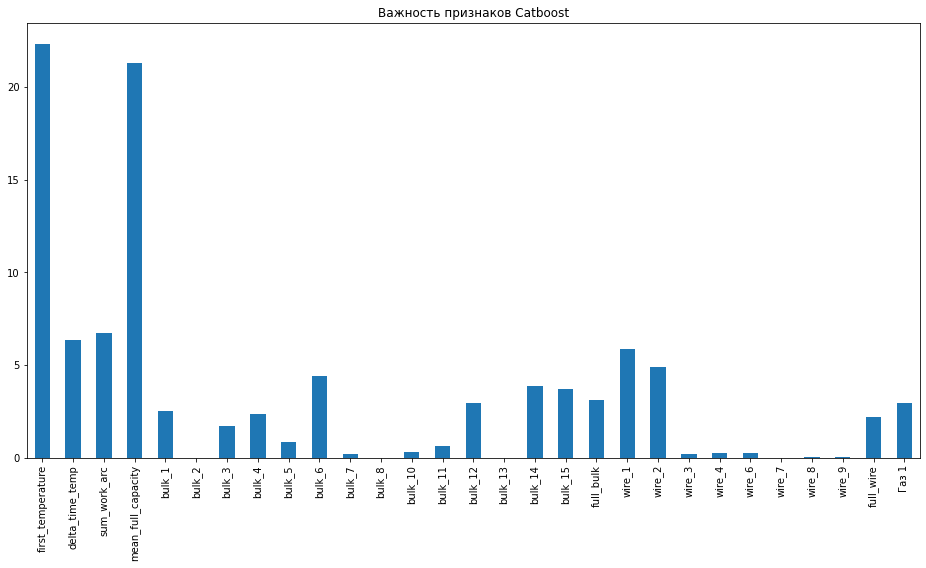

In [227]:
cat_imp = pd.Series(model_cat_mae.feature_importances_,
                         features_train.columns)
cat_imp.plot.bar(figsize=(16,8)).set_title("Важность признаков Catboost")

Для модели Catboost важны: первоначальная температура, средняя полная мощность, средняя работа электродов, время между замерами и wire 1. 

In [228]:
cat_imp = cat_imp.round(3)#[abs(cat_imp)< 0.01].round(3)

cat_imp = pd.DataFrame(cat_imp)
cat_imp.columns = ['cat']
cat_imp.reset_index(inplace = True)



In [229]:
del_imp = del_imp.merge(cat_imp, on = 'index', how='outer') 
del_imp

,index,tree,rfr,lr,cat
0,first_temperature,0.240,0.2899,0.195,22.350
1,delta_time_temp,0.092,0.0131,-0.153,6.365
2,sum_work_arc,0.079,0.0468,-49.568,6.701
3,mean_full_capacity,0.158,0.3236,39.951,21.292
4,bulk_1,0.007,0.0006,-0.145,2.506
5,bulk_2,0.000,0.0032,0.022,0.007
6,bulk_3,0.021,0.0004,-0.063,1.700
7,bulk_4,0.007,0.0025,-0.055,2.364
8,bulk_5,0.000,0.0000,-0.062,0.858
9,bulk_6,0.080,0.1137,-0.080,4.426


### Градиентный бустинг с LGBMRegressor

In [230]:
model_lgb = LGBMRegressor(random_state=RANDOM_STATE, objective='regression_l1')
model_lgb.fit(features_train, target_train)

LGBMRegressor(objective='regression_l1', random_state=130223)

In [232]:
predictions_lgb_train = model_lgb.predict(features_train)
#rmse_lgb_train = - cross_val_score(model_lgb, features_train, target_train, cv=5, scoring = rmse_scorer).mean()
mae_lgb_train = - cross_val_score(model_lgb, features_train, target_train, cv=5, scoring = mae_scorer).mean()

#print("RMSE градиентного бустинга с LGBMRegressor на обучении:", rmse_lgb_train)
print("MAE градиентного бустинга с LGBMRegressor на обучении:", mae_lgb_train)


MAE градиентного бустинга с LGBMRegressor на обучении: 5.6010861710964805


In [233]:
rmse_lgb_train = - cross_val_score(model_lgb, features_train, target_train, cv=5, scoring = rmse_scorer).mean()
print("RMSE градиентного бустинга с LGBMRegressor на обучении:", rmse_lgb_train)

RMSE градиентного бустинга с LGBMRegressor на обучении: 7.918660698268137


Text(0.5, 1.0, 'Важность признаков LGBMRegressor')

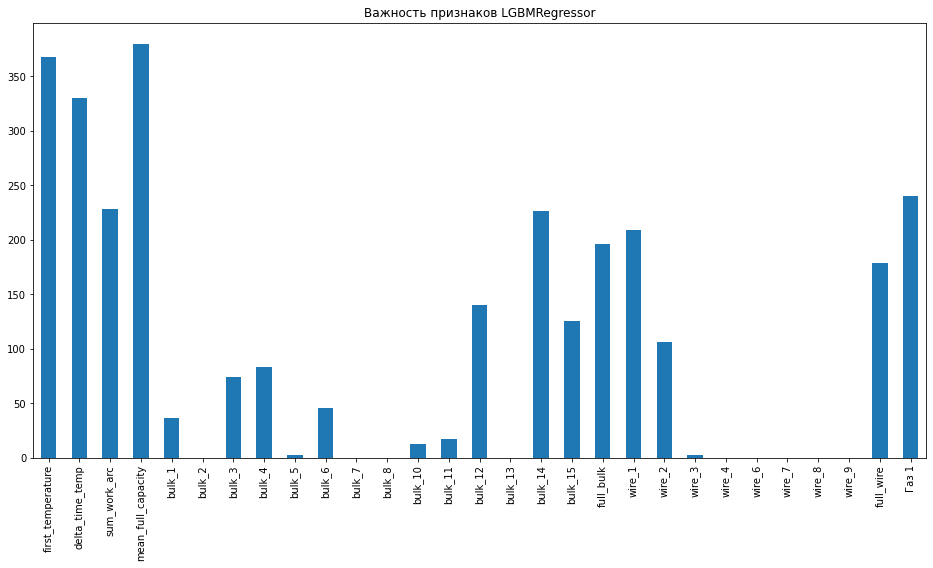

In [234]:
lgb_imp = pd.Series(model_lgb.feature_importances_,
                         features_train.columns)
lgb_imp.plot.bar(figsize=(16,8)).set_title("Важность признаков LGBMRegressor")


Для модели LGBMRegressor важны: первоначальная температура, средняя полная мощность, средняя работа электродов, время между замерами и bulk 14. И здесь уровень влияния номера key самый высокий. Это плохо, это не валидно, нужно убрать.

In [235]:
lgb_imp = lgb_imp.round(3)#[abs(lgb_imp)< 0.01].round(3)

lgb_imp = pd.DataFrame(lgb_imp)
lgb_imp.columns = ['lgb']
lgb_imp.reset_index(inplace = True)



In [236]:
del_imp = del_imp.merge(lgb_imp, on = 'index', how='outer') 

1. RMSE градиентного бустинга с LGBMRegressor на обучении: 7.83, LGBMRegressor(random_state=RANDOM_STATE
2. RMSE градиентного бустинга с LGBMRegressor на обучении: 7.91, objective='regression_l1'.

Кажется, у нас готов победитель, но для надёжности сведём результаты в таблицу.


## Анализ моделей

Представим результаты нашей работы в таблице

In [237]:
data = {'RMSE на обучении ':[rmse_dummy_train, rmse_tr_train, rmse_rf_train, rmse_lr_train,
                             rmse_lrh_train, rmse_cat_train, rmse_lgb_train] } 
# Creates pandas DataFrame. 
plt = pd.DataFrame(data, index =['Dummy модель', 'Дерево решений', 'Случайный лес', 'Линейная регрессия',
                                 'Линейная регрессия ручная SGD', 'Градиентный бустинг с CatBoost', 'Градиентный бустинг с LGBMRegressor']) 

display(plt.sort_values('RMSE на обучении '))

,RMSE на обучении
Градиентный бустинг с CatBoost,7.602239
Градиентный бустинг с LGBMRegressor,7.918661
Случайный лес,8.982477
Линейная регрессия,9.230702
Дерево решений,9.537881
Dummy модель,11.288534
Линейная регрессия ручная SGD,51.822910


Да, на первом месте у нас **Градиентный бустинг с CatBoost с победной метрикой RMSE на кросс-валидации 7.60**

In [238]:
del_imp

,index,tree,rfr,lr,cat,lgb
0,first_temperature,0.240,0.2899,0.195,22.350,368
1,delta_time_temp,0.092,0.0131,-0.153,6.365,330
2,sum_work_arc,0.079,0.0468,-49.568,6.701,228
3,mean_full_capacity,0.158,0.3236,39.951,21.292,380
4,bulk_1,0.007,0.0006,-0.145,2.506,36
5,bulk_2,0.000,0.0032,0.022,0.007,0
6,bulk_3,0.021,0.0004,-0.063,1.700,74
7,bulk_4,0.007,0.0025,-0.055,2.364,83
8,bulk_5,0.000,0.0000,-0.062,0.858,2
9,bulk_6,0.080,0.1137,-0.080,4.426,46


### Предсказания модели

In [239]:
predictions_cat_test = model_cat.predict(features_test)
rmse_cat_test = rmse(target_test, predictions_cat_test)
print("RMSE градиентного бустинга с CatBoost, тест:", rmse_cat_test)

RMSE градиентного бустинга с CatBoost, тест: 7.520813908841955


In [240]:
mean_absolute_error(predictions_cat_test, target_test)

5.519067765407376

Мы могли бы закончить на этом, но ведь обещали убрать зависимость от key и лишние столбцы. Чтобы видеть, как это сказывается на результате - сделаем это пошагово, сперва превратим ключ в индекс.

In [241]:
cat_imp

,index,cat
0,first_temperature,22.350
1,delta_time_temp,6.365
2,sum_work_arc,6.701
3,mean_full_capacity,21.292
4,bulk_1,2.506
5,bulk_2,0.007
6,bulk_3,1.700
7,bulk_4,2.364
8,bulk_5,0.858
9,bulk_6,4.426


Почти нулевых осталось не так много, в этот прогон удаляли раньше. Уберем bulk_2 c 0.002 и  wire_7 c 0.000

In [244]:
features_test = features_test.drop(['bulk_8','wire_7','bulk_2'], axis = 1)

Обучим заново:

In [245]:
model_cat.fit(features_train, target_train,verbose=10, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.067731
0:	learn: 11.0760853	total: 9.51ms	remaining: 5.7s
10:	learn: 9.4851003	total: 55.2ms	remaining: 2.96s
20:	learn: 8.6605837	total: 115ms	remaining: 3.18s
30:	learn: 8.1293632	total: 157ms	remaining: 2.88s
40:	learn: 7.7918585	total: 198ms	remaining: 2.69s
50:	learn: 7.4690462	total: 242ms	remaining: 2.6s
60:	learn: 7.2066818	total: 280ms	remaining: 2.47s
70:	learn: 6.9904021	total: 318ms	remaining: 2.37s
80:	learn: 6.7688577	total: 368ms	remaining: 2.36s
90:	learn: 6.5805518	total: 413ms	remaining: 2.31s
100:	learn: 6.4289526	total: 452ms	remaining: 2.23s
110:	learn: 6.2655602	total: 491ms	remaining: 2.16s
120:	learn: 6.1169833	total: 534ms	remaining: 2.12s
130:	learn: 5.9901448	total: 575ms	remaining: 2.06s
140:	learn: 5.8514032	total: 615ms	remaining: 2s
150:	learn: 5.7260737	total: 655ms	remaining: 1.95s
160:	learn: 5.6066887	total: 696ms	remaining: 1.9s
170:	learn: 5.5127082	total: 747ms	remaining: 1.87s
180:	learn: 5.4135168	total: 785ms	remaining: 1.

In [246]:
predictions_cat_train = model_cat.predict(features_train)

rmse_cat_train = - cross_val_score(model_cat, features_train, target_train, cv=5, scoring = rmse_scorer).mean()
print("RMSE градиентного бустинга с CatBoost на обучении:", rmse_cat_train)


Learning rate set to 0.065378
0:	learn: 11.3245620	total: 5.94ms	remaining: 3.56s
1:	learn: 11.1524033	total: 11.3ms	remaining: 3.37s
2:	learn: 10.9662081	total: 16.7ms	remaining: 3.32s
3:	learn: 10.7947897	total: 21.6ms	remaining: 3.22s
4:	learn: 10.6269572	total: 26.3ms	remaining: 3.13s
5:	learn: 10.4719423	total: 30ms	remaining: 2.97s
6:	learn: 10.3249291	total: 33.8ms	remaining: 2.86s
7:	learn: 10.1513769	total: 37.3ms	remaining: 2.76s
8:	learn: 10.0160706	total: 40.9ms	remaining: 2.69s
9:	learn: 9.8890267	total: 44.6ms	remaining: 2.63s
10:	learn: 9.7696812	total: 48ms	remaining: 2.57s
11:	learn: 9.6401077	total: 51.3ms	remaining: 2.51s
12:	learn: 9.5350825	total: 54.7ms	remaining: 2.47s
13:	learn: 9.4597446	total: 58ms	remaining: 2.43s
14:	learn: 9.3868847	total: 61.5ms	remaining: 2.4s
15:	learn: 9.2882046	total: 65.1ms	remaining: 2.37s
16:	learn: 9.2109510	total: 68.6ms	remaining: 2.35s
17:	learn: 9.1307496	total: 72.2ms	remaining: 2.33s
18:	learn: 9.0491092	total: 75.7ms	remaini

184:	learn: 5.3096854	total: 822ms	remaining: 1.84s
185:	learn: 5.2971125	total: 826ms	remaining: 1.84s
186:	learn: 5.2872345	total: 830ms	remaining: 1.83s
187:	learn: 5.2842112	total: 833ms	remaining: 1.83s
188:	learn: 5.2764135	total: 837ms	remaining: 1.82s
189:	learn: 5.2652097	total: 842ms	remaining: 1.81s
190:	learn: 5.2622881	total: 845ms	remaining: 1.81s
191:	learn: 5.2497745	total: 850ms	remaining: 1.8s
192:	learn: 5.2357732	total: 853ms	remaining: 1.8s
193:	learn: 5.2335384	total: 857ms	remaining: 1.79s
194:	learn: 5.2194593	total: 861ms	remaining: 1.79s
195:	learn: 5.2070834	total: 865ms	remaining: 1.78s
196:	learn: 5.1975878	total: 868ms	remaining: 1.78s
197:	learn: 5.1889872	total: 872ms	remaining: 1.77s
198:	learn: 5.1849224	total: 876ms	remaining: 1.76s
199:	learn: 5.1727723	total: 881ms	remaining: 1.76s
200:	learn: 5.1535895	total: 884ms	remaining: 1.75s
201:	learn: 5.1358385	total: 889ms	remaining: 1.75s
202:	learn: 5.1255226	total: 893ms	remaining: 1.75s
203:	learn: 5.

356:	learn: 4.0158440	total: 1.55s	remaining: 1.06s
357:	learn: 4.0154469	total: 1.56s	remaining: 1.05s
358:	learn: 4.0142867	total: 1.56s	remaining: 1.05s
359:	learn: 4.0083616	total: 1.56s	remaining: 1.04s
360:	learn: 3.9995446	total: 1.57s	remaining: 1.04s
361:	learn: 3.9947963	total: 1.57s	remaining: 1.03s
362:	learn: 3.9904954	total: 1.58s	remaining: 1.03s
363:	learn: 3.9865269	total: 1.58s	remaining: 1.02s
364:	learn: 3.9838714	total: 1.58s	remaining: 1.02s
365:	learn: 3.9833312	total: 1.59s	remaining: 1.01s
366:	learn: 3.9768780	total: 1.59s	remaining: 1.01s
367:	learn: 3.9725847	total: 1.6s	remaining: 1.01s
368:	learn: 3.9653142	total: 1.6s	remaining: 1s
369:	learn: 3.9609277	total: 1.6s	remaining: 997ms
370:	learn: 3.9578500	total: 1.61s	remaining: 993ms
371:	learn: 3.9516320	total: 1.61s	remaining: 990ms
372:	learn: 3.9453238	total: 1.62s	remaining: 987ms
373:	learn: 3.9409147	total: 1.63s	remaining: 983ms
374:	learn: 3.9404502	total: 1.63s	remaining: 980ms
375:	learn: 3.9375

530:	learn: 3.1713839	total: 2.28s	remaining: 297ms
531:	learn: 3.1703197	total: 2.29s	remaining: 292ms
532:	learn: 3.1657542	total: 2.29s	remaining: 288ms
533:	learn: 3.1578535	total: 2.29s	remaining: 283ms
534:	learn: 3.1525348	total: 2.3s	remaining: 279ms
535:	learn: 3.1459443	total: 2.3s	remaining: 275ms
536:	learn: 3.1414887	total: 2.3s	remaining: 270ms
537:	learn: 3.1366815	total: 2.31s	remaining: 266ms
538:	learn: 3.1359904	total: 2.31s	remaining: 262ms
539:	learn: 3.1308075	total: 2.31s	remaining: 257ms
540:	learn: 3.1273559	total: 2.32s	remaining: 253ms
541:	learn: 3.1227304	total: 2.32s	remaining: 248ms
542:	learn: 3.1191087	total: 2.33s	remaining: 244ms
543:	learn: 3.1146992	total: 2.33s	remaining: 240ms
544:	learn: 3.1096271	total: 2.33s	remaining: 235ms
545:	learn: 3.1064129	total: 2.34s	remaining: 231ms
546:	learn: 3.1006026	total: 2.34s	remaining: 227ms
547:	learn: 3.0936050	total: 2.35s	remaining: 223ms
548:	learn: 3.0868913	total: 2.35s	remaining: 218ms
549:	learn: 3.0

95:	learn: 6.3674422	total: 440ms	remaining: 2.31s
96:	learn: 6.3537732	total: 444ms	remaining: 2.3s
97:	learn: 6.3397938	total: 449ms	remaining: 2.3s
98:	learn: 6.3132248	total: 453ms	remaining: 2.29s
99:	learn: 6.2944176	total: 457ms	remaining: 2.28s
100:	learn: 6.2834276	total: 461ms	remaining: 2.28s
101:	learn: 6.2680489	total: 465ms	remaining: 2.27s
102:	learn: 6.2562459	total: 469ms	remaining: 2.26s
103:	learn: 6.2447044	total: 473ms	remaining: 2.25s
104:	learn: 6.2335395	total: 477ms	remaining: 2.25s
105:	learn: 6.2180973	total: 480ms	remaining: 2.24s
106:	learn: 6.2049623	total: 484ms	remaining: 2.23s
107:	learn: 6.1866096	total: 488ms	remaining: 2.22s
108:	learn: 6.1637611	total: 492ms	remaining: 2.21s
109:	learn: 6.1432306	total: 496ms	remaining: 2.21s
110:	learn: 6.1325618	total: 499ms	remaining: 2.2s
111:	learn: 6.1149830	total: 505ms	remaining: 2.2s
112:	learn: 6.0969935	total: 509ms	remaining: 2.19s
113:	learn: 6.0844736	total: 513ms	remaining: 2.19s
114:	learn: 6.0740730

254:	learn: 4.5663258	total: 1.17s	remaining: 1.58s
255:	learn: 4.5586433	total: 1.17s	remaining: 1.57s
256:	learn: 4.5524736	total: 1.17s	remaining: 1.57s
257:	learn: 4.5481226	total: 1.18s	remaining: 1.56s
258:	learn: 4.5409767	total: 1.19s	remaining: 1.56s
259:	learn: 4.5319625	total: 1.19s	remaining: 1.55s
260:	learn: 4.5262981	total: 1.19s	remaining: 1.55s
261:	learn: 4.5138690	total: 1.2s	remaining: 1.55s
262:	learn: 4.5025747	total: 1.2s	remaining: 1.54s
263:	learn: 4.4934730	total: 1.21s	remaining: 1.54s
264:	learn: 4.4761445	total: 1.21s	remaining: 1.53s
265:	learn: 4.4678742	total: 1.22s	remaining: 1.53s
266:	learn: 4.4571145	total: 1.22s	remaining: 1.52s
267:	learn: 4.4495095	total: 1.22s	remaining: 1.51s
268:	learn: 4.4434329	total: 1.23s	remaining: 1.51s
269:	learn: 4.4419148	total: 1.23s	remaining: 1.5s
270:	learn: 4.4313876	total: 1.24s	remaining: 1.5s
271:	learn: 4.4255638	total: 1.24s	remaining: 1.5s
272:	learn: 4.4157558	total: 1.24s	remaining: 1.49s
273:	learn: 4.410

416:	learn: 3.6189516	total: 1.9s	remaining: 835ms
417:	learn: 3.6121620	total: 1.91s	remaining: 830ms
418:	learn: 3.6114787	total: 1.91s	remaining: 825ms
419:	learn: 3.6049971	total: 1.91s	remaining: 820ms
420:	learn: 3.6046132	total: 1.92s	remaining: 816ms
421:	learn: 3.5979119	total: 1.92s	remaining: 811ms
422:	learn: 3.5892274	total: 1.93s	remaining: 806ms
423:	learn: 3.5875168	total: 1.93s	remaining: 801ms
424:	learn: 3.5801190	total: 1.93s	remaining: 796ms
425:	learn: 3.5785183	total: 1.94s	remaining: 791ms
426:	learn: 3.5717691	total: 1.94s	remaining: 786ms
427:	learn: 3.5599242	total: 1.94s	remaining: 782ms
428:	learn: 3.5586048	total: 1.95s	remaining: 777ms
429:	learn: 3.5499547	total: 1.95s	remaining: 772ms
430:	learn: 3.5487787	total: 1.96s	remaining: 768ms
431:	learn: 3.5438040	total: 1.96s	remaining: 764ms
432:	learn: 3.5395116	total: 1.97s	remaining: 760ms
433:	learn: 3.5349083	total: 1.98s	remaining: 756ms
434:	learn: 3.5315393	total: 1.98s	remaining: 753ms
435:	learn: 3

576:	learn: 3.0212490	total: 2.63s	remaining: 105ms
577:	learn: 3.0134102	total: 2.64s	remaining: 100ms
578:	learn: 3.0109350	total: 2.64s	remaining: 95.8ms
579:	learn: 3.0039450	total: 2.65s	remaining: 91.2ms
580:	learn: 2.9986901	total: 2.65s	remaining: 86.7ms
581:	learn: 2.9938866	total: 2.65s	remaining: 82.1ms
582:	learn: 2.9935072	total: 2.66s	remaining: 77.5ms
583:	learn: 2.9932509	total: 2.66s	remaining: 72.9ms
584:	learn: 2.9873426	total: 2.67s	remaining: 68.4ms
585:	learn: 2.9807977	total: 2.67s	remaining: 63.8ms
586:	learn: 2.9805843	total: 2.67s	remaining: 59.2ms
587:	learn: 2.9804102	total: 2.68s	remaining: 54.6ms
588:	learn: 2.9802077	total: 2.68s	remaining: 50.1ms
589:	learn: 2.9760803	total: 2.69s	remaining: 45.5ms
590:	learn: 2.9728763	total: 2.69s	remaining: 41ms
591:	learn: 2.9699719	total: 2.69s	remaining: 36.4ms
592:	learn: 2.9649999	total: 2.7s	remaining: 31.8ms
593:	learn: 2.9591303	total: 2.7s	remaining: 27.3ms
594:	learn: 2.9556923	total: 2.7s	remaining: 22.7ms


149:	learn: 5.6874685	total: 586ms	remaining: 1.76s
150:	learn: 5.6847928	total: 591ms	remaining: 1.76s
151:	learn: 5.6625608	total: 595ms	remaining: 1.75s
152:	learn: 5.6575730	total: 599ms	remaining: 1.75s
153:	learn: 5.6387450	total: 602ms	remaining: 1.74s
154:	learn: 5.6222493	total: 606ms	remaining: 1.74s
155:	learn: 5.6129339	total: 613ms	remaining: 1.74s
156:	learn: 5.6030776	total: 619ms	remaining: 1.75s
157:	learn: 5.5993054	total: 621ms	remaining: 1.74s
158:	learn: 5.5865936	total: 628ms	remaining: 1.74s
159:	learn: 5.5692574	total: 634ms	remaining: 1.74s
160:	learn: 5.5535647	total: 640ms	remaining: 1.74s
161:	learn: 5.5393117	total: 644ms	remaining: 1.74s
162:	learn: 5.5270298	total: 647ms	remaining: 1.74s
163:	learn: 5.5079306	total: 651ms	remaining: 1.73s
164:	learn: 5.5060799	total: 655ms	remaining: 1.73s
165:	learn: 5.4942622	total: 658ms	remaining: 1.72s
166:	learn: 5.4910072	total: 662ms	remaining: 1.72s
167:	learn: 5.4851845	total: 665ms	remaining: 1.71s
168:	learn: 

327:	learn: 4.1502233	total: 1.31s	remaining: 1.09s
328:	learn: 4.1444775	total: 1.32s	remaining: 1.09s
329:	learn: 4.1381664	total: 1.33s	remaining: 1.08s
330:	learn: 4.1335854	total: 1.33s	remaining: 1.08s
331:	learn: 4.1283838	total: 1.33s	remaining: 1.08s
332:	learn: 4.1179536	total: 1.34s	remaining: 1.07s
333:	learn: 4.1101933	total: 1.34s	remaining: 1.07s
334:	learn: 4.1046230	total: 1.35s	remaining: 1.07s
335:	learn: 4.1007734	total: 1.35s	remaining: 1.06s
336:	learn: 4.0938479	total: 1.35s	remaining: 1.06s
337:	learn: 4.0909678	total: 1.36s	remaining: 1.05s
338:	learn: 4.0805755	total: 1.36s	remaining: 1.05s
339:	learn: 4.0726986	total: 1.37s	remaining: 1.04s
340:	learn: 4.0657077	total: 1.37s	remaining: 1.04s
341:	learn: 4.0650010	total: 1.38s	remaining: 1.04s
342:	learn: 4.0542060	total: 1.38s	remaining: 1.03s
343:	learn: 4.0494873	total: 1.39s	remaining: 1.03s
344:	learn: 4.0415327	total: 1.39s	remaining: 1.03s
345:	learn: 4.0343923	total: 1.4s	remaining: 1.03s
346:	learn: 4

507:	learn: 3.1933752	total: 2.05s	remaining: 371ms
508:	learn: 3.1891244	total: 2.05s	remaining: 367ms
509:	learn: 3.1807637	total: 2.06s	remaining: 363ms
510:	learn: 3.1802680	total: 2.06s	remaining: 359ms
511:	learn: 3.1755267	total: 2.07s	remaining: 355ms
512:	learn: 3.1713337	total: 2.07s	remaining: 351ms
513:	learn: 3.1678040	total: 2.07s	remaining: 347ms
514:	learn: 3.1626304	total: 2.08s	remaining: 343ms
515:	learn: 3.1572119	total: 2.08s	remaining: 339ms
516:	learn: 3.1538059	total: 2.09s	remaining: 335ms
517:	learn: 3.1509914	total: 2.09s	remaining: 331ms
518:	learn: 3.1448407	total: 2.1s	remaining: 327ms
519:	learn: 3.1421270	total: 2.1s	remaining: 323ms
520:	learn: 3.1395721	total: 2.1s	remaining: 319ms
521:	learn: 3.1365744	total: 2.11s	remaining: 315ms
522:	learn: 3.1329745	total: 2.11s	remaining: 311ms
523:	learn: 3.1327244	total: 2.12s	remaining: 307ms
524:	learn: 3.1286407	total: 2.12s	remaining: 303ms
525:	learn: 3.1227322	total: 2.13s	remaining: 299ms
526:	learn: 3.1

91:	learn: 6.6898435	total: 394ms	remaining: 2.17s
92:	learn: 6.6746189	total: 400ms	remaining: 2.18s
93:	learn: 6.6623569	total: 413ms	remaining: 2.22s
94:	learn: 6.6474540	total: 419ms	remaining: 2.23s
95:	learn: 6.6214510	total: 426ms	remaining: 2.23s
96:	learn: 6.6045622	total: 433ms	remaining: 2.24s
97:	learn: 6.5751811	total: 437ms	remaining: 2.24s
98:	learn: 6.5587733	total: 443ms	remaining: 2.24s
99:	learn: 6.5359306	total: 449ms	remaining: 2.24s
100:	learn: 6.5119795	total: 454ms	remaining: 2.24s
101:	learn: 6.5023656	total: 459ms	remaining: 2.24s
102:	learn: 6.4841303	total: 464ms	remaining: 2.24s
103:	learn: 6.4786528	total: 471ms	remaining: 2.25s
104:	learn: 6.4708778	total: 477ms	remaining: 2.25s
105:	learn: 6.4557252	total: 484ms	remaining: 2.25s
106:	learn: 6.4398350	total: 489ms	remaining: 2.25s
107:	learn: 6.4288244	total: 494ms	remaining: 2.25s
108:	learn: 6.4108915	total: 499ms	remaining: 2.25s
109:	learn: 6.3887273	total: 504ms	remaining: 2.25s
110:	learn: 6.3750592

277:	learn: 4.4757229	total: 1.29s	remaining: 1.5s
278:	learn: 4.4626910	total: 1.3s	remaining: 1.49s
279:	learn: 4.4521819	total: 1.3s	remaining: 1.49s
280:	learn: 4.4470270	total: 1.31s	remaining: 1.49s
281:	learn: 4.4376932	total: 1.32s	remaining: 1.48s
282:	learn: 4.4305398	total: 1.32s	remaining: 1.48s
283:	learn: 4.4238420	total: 1.33s	remaining: 1.48s
284:	learn: 4.4163471	total: 1.33s	remaining: 1.48s
285:	learn: 4.4055346	total: 1.34s	remaining: 1.47s
286:	learn: 4.4000619	total: 1.35s	remaining: 1.47s
287:	learn: 4.3954579	total: 1.35s	remaining: 1.47s
288:	learn: 4.3889529	total: 1.36s	remaining: 1.46s
289:	learn: 4.3799180	total: 1.37s	remaining: 1.46s
290:	learn: 4.3729994	total: 1.37s	remaining: 1.46s
291:	learn: 4.3669844	total: 1.38s	remaining: 1.46s
292:	learn: 4.3554665	total: 1.39s	remaining: 1.45s
293:	learn: 4.3454499	total: 1.39s	remaining: 1.45s
294:	learn: 4.3399726	total: 1.39s	remaining: 1.44s
295:	learn: 4.3340766	total: 1.4s	remaining: 1.44s
296:	learn: 4.32

457:	learn: 3.4745378	total: 2.19s	remaining: 677ms
458:	learn: 3.4709862	total: 2.19s	remaining: 673ms
459:	learn: 3.4649645	total: 2.19s	remaining: 667ms
460:	learn: 3.4605359	total: 2.2s	remaining: 662ms
461:	learn: 3.4531781	total: 2.2s	remaining: 657ms
462:	learn: 3.4491757	total: 2.2s	remaining: 652ms
463:	learn: 3.4436788	total: 2.21s	remaining: 647ms
464:	learn: 3.4389933	total: 2.21s	remaining: 642ms
465:	learn: 3.4348713	total: 2.21s	remaining: 637ms
466:	learn: 3.4283219	total: 2.22s	remaining: 632ms
467:	learn: 3.4232753	total: 2.22s	remaining: 627ms
468:	learn: 3.4191924	total: 2.23s	remaining: 622ms
469:	learn: 3.4187641	total: 2.23s	remaining: 617ms
470:	learn: 3.4097785	total: 2.23s	remaining: 612ms
471:	learn: 3.4032486	total: 2.24s	remaining: 607ms
472:	learn: 3.3984740	total: 2.24s	remaining: 602ms
473:	learn: 3.3954752	total: 2.25s	remaining: 597ms
474:	learn: 3.3932646	total: 2.25s	remaining: 592ms
475:	learn: 3.3885159	total: 2.25s	remaining: 587ms
476:	learn: 3.3

37:	learn: 7.8805208	total: 233ms	remaining: 3.44s
38:	learn: 7.8335987	total: 238ms	remaining: 3.42s
39:	learn: 7.7992397	total: 244ms	remaining: 3.42s
40:	learn: 7.7694889	total: 251ms	remaining: 3.42s
41:	learn: 7.7124456	total: 258ms	remaining: 3.43s
42:	learn: 7.6743611	total: 265ms	remaining: 3.43s
43:	learn: 7.6465182	total: 272ms	remaining: 3.44s
44:	learn: 7.6212802	total: 279ms	remaining: 3.44s
45:	learn: 7.5785263	total: 285ms	remaining: 3.44s
46:	learn: 7.5416493	total: 292ms	remaining: 3.44s
47:	learn: 7.5100392	total: 299ms	remaining: 3.44s
48:	learn: 7.4549622	total: 306ms	remaining: 3.44s
49:	learn: 7.4249463	total: 312ms	remaining: 3.43s
50:	learn: 7.3885581	total: 319ms	remaining: 3.43s
51:	learn: 7.3735448	total: 326ms	remaining: 3.43s
52:	learn: 7.3363989	total: 332ms	remaining: 3.43s
53:	learn: 7.3096338	total: 339ms	remaining: 3.42s
54:	learn: 7.2712871	total: 345ms	remaining: 3.42s
55:	learn: 7.2410306	total: 352ms	remaining: 3.42s
56:	learn: 7.2156828	total: 358

208:	learn: 4.7880066	total: 1.14s	remaining: 2.13s
209:	learn: 4.7756437	total: 1.15s	remaining: 2.14s
210:	learn: 4.7593092	total: 1.16s	remaining: 2.13s
211:	learn: 4.7542076	total: 1.16s	remaining: 2.13s
212:	learn: 4.7476291	total: 1.17s	remaining: 2.12s
213:	learn: 4.7334408	total: 1.17s	remaining: 2.12s
214:	learn: 4.7257011	total: 1.18s	remaining: 2.11s
215:	learn: 4.7167889	total: 1.19s	remaining: 2.11s
216:	learn: 4.7044647	total: 1.19s	remaining: 2.11s
217:	learn: 4.6935538	total: 1.2s	remaining: 2.1s
218:	learn: 4.6808499	total: 1.21s	remaining: 2.1s
219:	learn: 4.6770341	total: 1.21s	remaining: 2.09s
220:	learn: 4.6708165	total: 1.22s	remaining: 2.09s
221:	learn: 4.6646555	total: 1.22s	remaining: 2.08s
222:	learn: 4.6494683	total: 1.23s	remaining: 2.08s
223:	learn: 4.6428640	total: 1.24s	remaining: 2.08s
224:	learn: 4.6358791	total: 1.24s	remaining: 2.07s
225:	learn: 4.6306151	total: 1.25s	remaining: 2.06s
226:	learn: 4.6274774	total: 1.25s	remaining: 2.06s
227:	learn: 4.6

382:	learn: 3.6148147	total: 1.88s	remaining: 1.07s
383:	learn: 3.6066414	total: 1.89s	remaining: 1.06s
384:	learn: 3.6000301	total: 1.9s	remaining: 1.06s
385:	learn: 3.5990762	total: 1.9s	remaining: 1.05s
386:	learn: 3.5927834	total: 1.91s	remaining: 1.05s
387:	learn: 3.5859882	total: 1.92s	remaining: 1.05s
388:	learn: 3.5788740	total: 1.92s	remaining: 1.04s
389:	learn: 3.5781884	total: 1.93s	remaining: 1.04s
390:	learn: 3.5713328	total: 1.93s	remaining: 1.03s
391:	learn: 3.5640298	total: 1.93s	remaining: 1.03s
392:	learn: 3.5551529	total: 1.94s	remaining: 1.02s
393:	learn: 3.5469985	total: 1.94s	remaining: 1.02s
394:	learn: 3.5463385	total: 1.95s	remaining: 1.01s
395:	learn: 3.5413434	total: 1.96s	remaining: 1.01s
396:	learn: 3.5366864	total: 1.96s	remaining: 1s
397:	learn: 3.5290889	total: 1.97s	remaining: 998ms
398:	learn: 3.5238273	total: 1.97s	remaining: 993ms
399:	learn: 3.5184653	total: 1.97s	remaining: 987ms
400:	learn: 3.5082246	total: 1.98s	remaining: 982ms
401:	learn: 3.502

547:	learn: 2.9167355	total: 2.63s	remaining: 249ms
548:	learn: 2.9122444	total: 2.63s	remaining: 244ms
549:	learn: 2.9074766	total: 2.63s	remaining: 240ms
550:	learn: 2.9031650	total: 2.64s	remaining: 235ms
551:	learn: 2.9006178	total: 2.65s	remaining: 230ms
552:	learn: 2.8970818	total: 2.65s	remaining: 225ms
553:	learn: 2.8936832	total: 2.66s	remaining: 221ms
554:	learn: 2.8934186	total: 2.67s	remaining: 216ms
555:	learn: 2.8930150	total: 2.67s	remaining: 211ms
556:	learn: 2.8892756	total: 2.68s	remaining: 207ms
557:	learn: 2.8863547	total: 2.68s	remaining: 202ms
558:	learn: 2.8817329	total: 2.69s	remaining: 197ms
559:	learn: 2.8756446	total: 2.7s	remaining: 193ms
560:	learn: 2.8737043	total: 2.7s	remaining: 188ms
561:	learn: 2.8683018	total: 2.71s	remaining: 183ms
562:	learn: 2.8680030	total: 2.71s	remaining: 178ms
563:	learn: 2.8617199	total: 2.72s	remaining: 173ms
564:	learn: 2.8568641	total: 2.72s	remaining: 169ms
565:	learn: 2.8541032	total: 2.73s	remaining: 164ms
566:	learn: 2.

И стало чуть хуже, остановимся на предыдущем шаге.

**Вывод** нашей победительницей стала модель градиентного бустинга Catboost, показавшая на кросс-валидации рекордное rmse 7.60.

RMSE градиентного бустинга с CatBoost, тест: 7.52. И, наконец, **МАЕ модели - победительницы - 5.519**

Немного удивительно, что мое предположение использовать rmse на кросс-валидации так хорошо выстрелило. (естественно я посмотрела альтернативную ветку с МАЕ, и там было хуже, не то, чтобы очень, в норматив проходило, но хуже.

# ОТЧЕТ ПО ПРОЕКТУ

# оптимизация производственных расходов металлургического комбината

# Описание проекта

Цель проекта - оптимизировать производственные расходы путем снижения расходов на электроэнергию. Заказчик -  металлургический комбинат ООО «Так закаляем сталь». Заказчик решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали. 

**Описание технического процесса от заказчика**
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Дополнительная информация**

В ходе обсуждений с заказчиком получена дополнительная информация:
1. Установлена целевая переменная - это конечная температура розлива металла. Паспортная температура плавления - около 1500 градусов С. Поднимать температуру выше не нужно, так как уже достигнуто плавление содержимого ковша.
2. Превышение температуры нежелательно ещё и потому, что ведет к разрушению облицовки и повышенному износу, помимо экономии электроэнергии, при снижении температуры достигается экономия средств на планово-профилактический ремонт.
3. Газ используется для перемешивания раствора в ковше.
4. Объект моделирования – ковш. 


**Выполнена предобработка и исследовательский анализ данных.**

В ходе исследовательского анализа данных выявлено, что часть таблиц содержит пропуски в столбцах, 
* data_arc - полностью заполнен. 
* data_bulk - Пропуски в 15 столбцах из 16. Полностью заполнены и не содержат пропусков только столбец ['key'],
* data_bulk_time - то же самое, доля пропусков: 76.2%
* data_gas - полностью заполнен,
* data_temp - таблица с температурой содержит пропуски в столбце ['Температура']. доля строк содержащих пропуски: 18.2%,
* data_wire, data_wire_time - Пропуски в 9 столбцах из 10, полностью заполнен опять только столбец key, все строки содержат пропуски.

Помимо пропусков, все названия призхнаков приведены к нижнему регистроу, "змеиный" стиль.

Выявлено и исправлено отрицательное значение реактивной мощности, приводящее к искажению корреляции данных, заполнено медианой. После исправления стало отчетливо видно высокую корреляцию между активной и реактивной мощностью. 

**Диаграмма рассеяния, мощность**

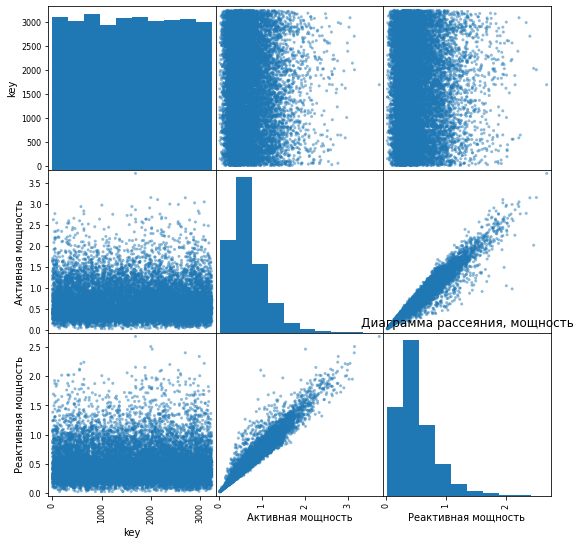

В этом разделе столбцы с датами заменены их разностью (временем прогрева) heating_time, добавлены full_capacity - полная мощность, работа электродов work_arc как произведение времени работы. После добавления новых признаков корреляция снизилась:

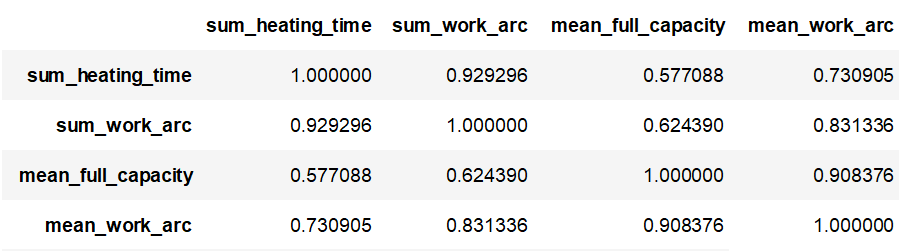

Проверка пропусков в данных о температуре показало наличие 18% строк, содержащих пропуски. **Рекомендовано** улучшить контроль над лабораторной дисциплиной, обеспечить звуковой сигнал для оператора в случае отказа оборудования и начала поступления нулевых значений. 

Так как заполнение данных любым способом привело бы к получению искаженных данных было принято решение удалять данные партий, по которым есть пропуски. 

Следует отметить, что по температуре есть несколько партий 1400, до 1200, что ниже точки плавления. Возможно, это нормальный процесс, связанный с особыми условиями, например, составом присадок.Это может быть и другой тип металла, так что учитываем и эти ковши. Мы приняли решение не удалять выбросы, поскольку это может привести к потере данных, созданию модели - обрубка, неспособной работать с реально встречающимися диапазонами температур.

Для оценки результата и дополнительного внимания заказчика нами  вводилась новая переменную, где 2 – обычные партии, а 0 – особые, меньше 1400, 1 - выше 1500 + допуск. Целевой температурой будем считать от 1470 до 1520 градусов. В предсказании итоговой температуры этот столбец не участвовал, но может быть использован заказчикам для анализа условий.
Забегая вперед отметим, что между многими показателями итогового свода данных была очень сильная корреляция. Чтобы это предодолеть, но не потерять "зашитые" в отдельных показателях особенности признаков, мы добпавили ряд переменных. Не все они вошли в окончательный набор признаков для модели, но все анализировались для подбора влияющих на точность параметров.

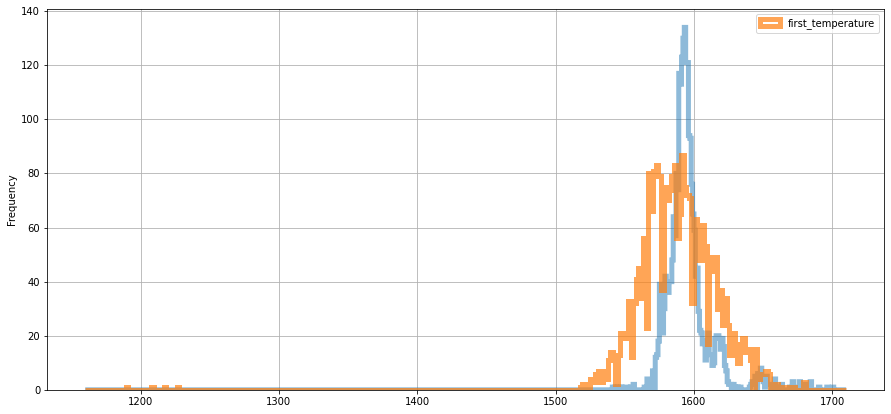

Температура показывает уверенный пик: средняя первоначальная - на 1588,	средняя после нагрева - 1595. Разница между средними температурами не слишком велика, но если мы посмотрим на наш добавленный признак Разница между самыми частыми значениями температур невелика, но если мы посмотрим разброс значений дельты температур, то увидим, что верхний квартиль - значения от 38.
от 20 до 38 - средняя разница температур. Минимальная дельта - ноль. 
Это неудивительно, ведь если у нас целевое значение температуры до 1500 градусов, то на графике видно, что почти все значения находятся в диапазоне выше. Задачу точно сформулировали некорректно, нужно выяснять детали и после этого пересматривать саму концепцию моделирования.

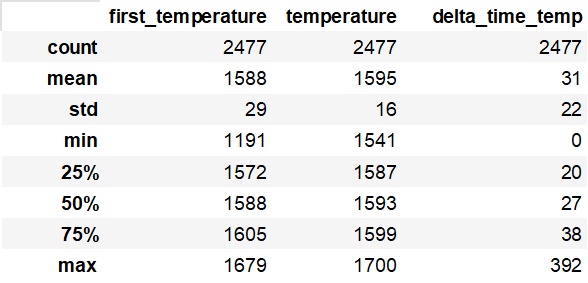

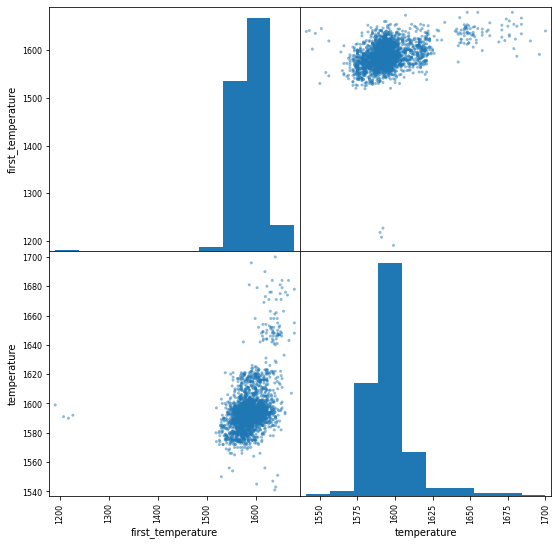

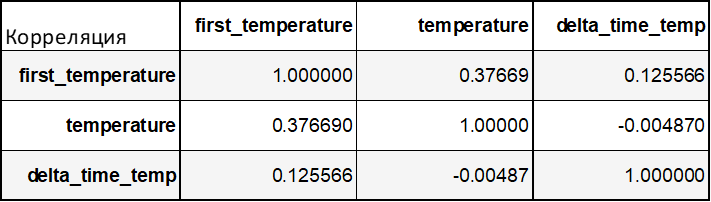

И снова корреляции, вызывающие вопросы: чем выше была первоначальная температура - тем дольше грели/мешали... интересно. Может быть, что-то тугоплавкое, особо кристаллизующееся. В любом случае, необходим вдумчивый анализ причин, почему первоначальная температура была выше желаемой. И почему в случаях с высокой температурой - нагревали до ещё более высоких значений.

В загрузках (присадок и проволоки) было выявлено, что пропуски соответствуют нулевым загрузкам соответствующих типов присадок и проволоки в ковш. Пропуски, в соответствии с полученной информацией, были заполнены нулями. Были добавлены совокупные объемы загрузки: full_bulk и full_wire.

Для объединения были подготовлены 5 таблиц: pivot_temp, pivot_arc, data_gas, full_wire, full_bulk. Для качественной модели нам нужны только те строки (ковши), где есть все данные. У нас было 3241 уникальных ключа в этих 5 таблицах, осталось 2329 полностью заполненных ковшей.

Далее был убран в индекс столбец key и были проверены корреляции для выявления мультиколлинеарности. Выявлено, что есть пары с очень высокой связью: mean_work_arc - mean_full_capacity 0.913

wire_8 - bulk_9 0.975

sum_work_arc - sum_heating_time 0.926

Для выводов, что полежит удалению, сделали первую итерацию создания моделей для оценки важности признаков. Результаты в таблице:

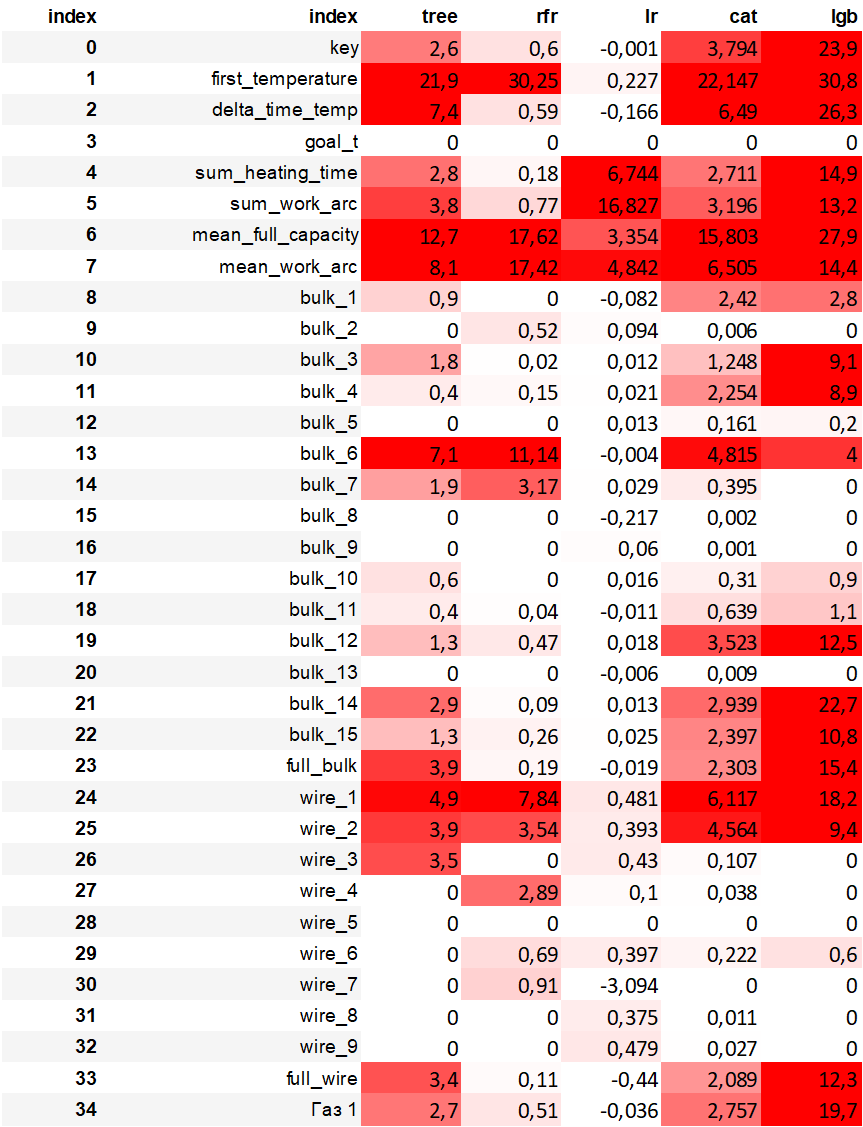

По результатам подбора моделей составлена таблица важности признаков. Из её анализа следует, что:

mean_work_arc проигрывает mean_full_capacity у всех, кроме линейной регрессии, сделаем отдельный выпуск для линейной регрессии.

wire_8 важнее, чем bulk_9, последний везде нулевой, удаляем.

важность sum_work_arc выше sum_heating_time у всех, кроме lgb бустинга. Но разница по lgb бустингу небольшая, всего 1 пункт, удалим sum_heating_time.

Введенная нами переменная goal_t не важна нигде, совсем. А также wire_5, удалим и её. Были удалены 'bulk_9', 'sum_heating_time','goal_t', 'wire_5'.

**Итоги предобработки и исследовательского анализа данных**

Обработаны пропуски и выбросы. Заполнены нулями  пропуски в (data_bulk и data_wire, data_wire_time) 

Удалены ковши с пропусками температуры.

Заполнены дополнительные переменные для учета влияния данных и снижения корреляции.  

Объединены таблицы по номеру ковша  key.

Удалены признаки, приводящие к мультиколлинеарности.

Все пункты изначального плана были выполнены, за исключением стратификации при разбиении на тестовую и тренировочную выборки, так как было большое количество одиночных значений по столбцам, разбить которые было автоматически невозможно, а удалять - не хотелось.

**Моделирование**

Для сравнения и последующего выбора были взяты следующие модели: 
1. Дерево решений
2. Случайный лес, 
3. Линейная регрессия, 
4. Линейная регрессия ручная SGD, 
5. Градиентный бустинг с CatBoost, 
6. Градиентный бустинг с LGBMRegressor,
7. Dummy модель для начального титрования результата. 

В качестве дщыы-функции использовалась RMSE, в качестве метрики качества - МАЕ. Нашей целью было получение модели с метрикой качества МАЕ не менее 6,8. После первого прогона были выявлены важные признаки, удалены признаки, приводящие к мультиколлинеарности. После этого выполнен ещё один прогон. Тредий прогон был осуществлен с лосс-функцией МАЕ, но все показатели получились хуже, и этот вариант был отвергнут. По итогам был проведен анализ метрики RMSE на кросс-валидации по моделям:



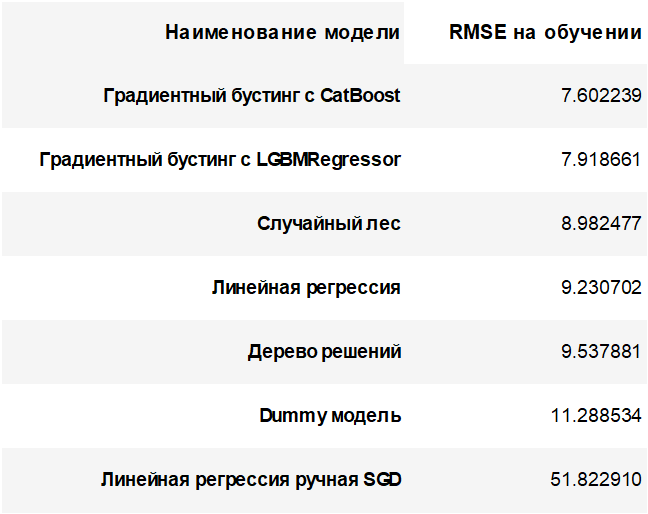

Победительницей стала модель Градиентный бустинг с CatBoost. Первое место **Градиентный бустинг с CatBoost с победной метрикой RMSE на кросс-валидации 7.60**

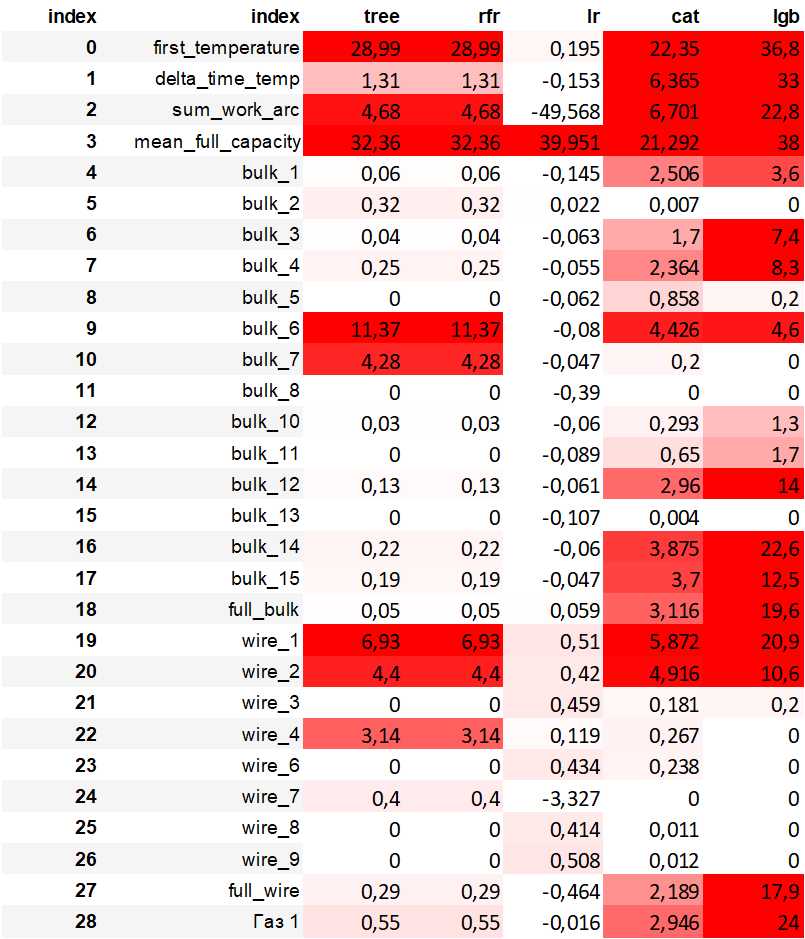

В таблице заметно, насколько по-разному выглядит важность признаков для моделей. В одном они согласны, mean full capacity, добавленная нами, очень важна. Для  Градиентного бустинга с CatBoost важны следующие признаки:

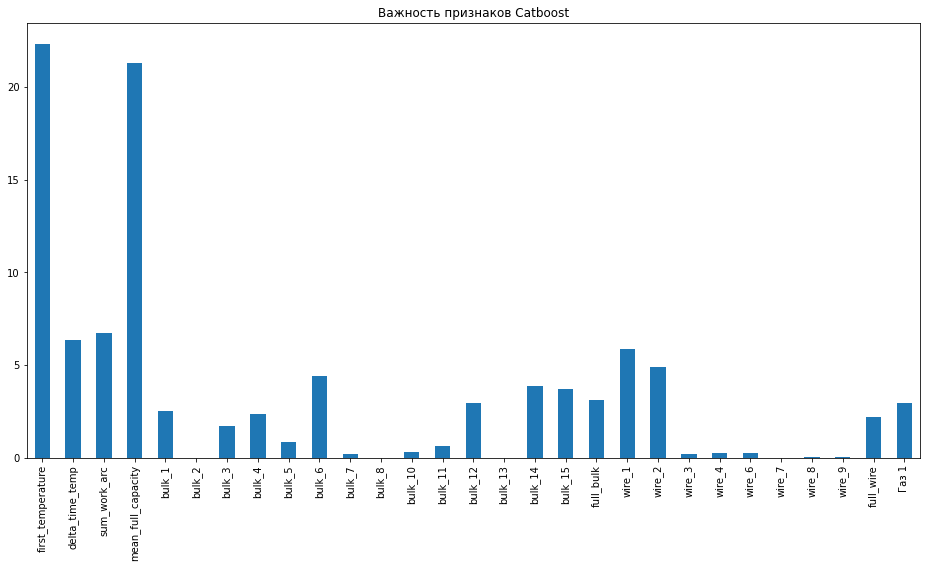

Для модели Catboost важны: первоначальная температура, средняя полная мощность, средняя работа электродов, время между замерами и wire 1. Кроме этого важны также наши добавленные признаки - время нагрева, суммарная работа электродов, суммарная загрузка балка и проволоки. Мы проверили и сравнили, с ними предсказания получаются точнее.

Окончательно убрать нулевые bulk_2 c 0.002, bulk_8 и wire_7 c 0.000 не вышло - RMSE на кросс-валидации чуть упало, принято решение оставить с текущим набором признаков.

Параметры модели CatBoostRegressor random_state=130223, loss_function="RMSE", iterations=700

Окончательно убрать нулевые bulk_2 c 0.002, bulk_8 и wire_7 c 0.000 не вышло - RMSE на кросс-валидации чуть упало, принято решение оставить с текущим набором признаков.

Параметры модели CatBoostRegressor random_state=130223, loss_function="RMSE", iterations=700

При помощи модели - победительницы мы получили предсказания и вычислили метрику МАЕ

Мean absolute error градиентного бустинга с **CatBoost, тест: 5.519067765407376**

Теперь об улучшении работы модели и получении полезных результатов. Первое, на что следует обратить внимание - лабораторная дисциплина. Не должно быть пропусков в измерении температуры. Второе - получение не асинхронных данных. В нашем датасете были столбцы, где замер первой температуры производился после нагрева, а не до. Порядок действий в СОП для оператора должен выглядеть так: первоначальный замер + замеры после каждой итерации - добавление веществ и перемешивание. Тогда можно будет построить новую модель, в которой можно будет учесть помимо вида добавок - их массу, которая является основным фактором падения температуры расплава, так как добавки вводятся неразогретыми. Можно будет подобрать эффективный объем добавок и подаваемой мощности и времени после их  добавления. Нужно выявить также, где возможно сократить время операций, поскольку любое простаивание ковша - это также теплопотери, приводящие к необходимости лишнего прогрева. Текущих данных для таких выводов недостаточно, рекомендуется продолжать наблюдения и обратиться к нам для следующего этапа анализа.

Более подробную информацию мы можем представить по запросу, не сомневайтесь и обращайтесь при возникновении любых вопросов.

Желаем успехов и экономии!